In [1]:
# %%
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:

import sys
import os
file_path = os.getcwd()
project_root = os.path.dirname(os.path.dirname(file_path))
print(project_root)
# Add the project root to the sys.path
if project_root not in sys.path:
    sys.path.append(project_root)
from Instant_AIV.models.NNpp import *
from Instant_AIV.models.metrics import *
from Instant_AIV.manage.plots import *
from Instant_AIV.manage.dataloader import *


# Libraries
import argparse
import numpy as np
import scipy.io
import time
import gc
import pandas as pd


#Plots
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import numpy as np
import jax
from jax import jit, grad, vmap, value_and_grad,jvp

from jax.config import config
import jax.numpy as jnp
import optax
import jaxopt

from typing import Tuple
import time


import h5py
from typing import List, Dict
from pyDOE import lhs
import tqdm
import scipy.integrate as integrate
from sklearn.model_selection import train_test_split
from matplotlib.ticker import FormatStrFormatter
print(project_root)


/users/jdtoscan/Documents/Intant_AIV/Instant-AIV
/users/jdtoscan/Documents/Intant_AIV/Instant-AIV


In [3]:

# %%
cmap = 'RdBu_r'
num_colors=8
# Create a colormap
cmap = plt.get_cmap(cmap)
colors = [cmap(i) for i in np.linspace(0, 1, num_colors)]
colors=colors[:num_colors//4]+colors[3*num_colors//4:]
print(len(colors))
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 20

4


## Tunning Parameters

In [4]:
parser = argparse.ArgumentParser(description='Tunning_parameters')
parser.add_argument('--run_type'   , type=str  , default='Rayleigh_Bernard_KAN_0628')
parser.add_argument('--Name' , type=str  , default='KAN_uvw_step_50')
parser.add_argument('--mode'       , type=str  , default='PINN')
parser.add_argument('--Run_MODE'   , type=str  , default='Plots')

parser.add_argument('--num_layer'  , type=int  , default=7)
parser.add_argument('--width_layer', type=int  , default=64)
parser.add_argument('--lr0', type=float  , default=0.0003)
parser.add_argument('--lrf', type=float  , default=0.00001)


parser.add_argument('--time_start' , type=int  , default=10)
parser.add_argument('--time_final' , type=int  , default=30)
parser.add_argument('--train_ratio' , type=float, default=0.5)

parser.add_argument('--batch_size' , type=int  , default=5000)
parser.add_argument('--num_gsteps' , type=int  , default=300*(10**3))
parser.add_argument('--Equal_Batch' , type=bool  , default=True)
parser.add_argument('--optimzer' , type=str  , default='AdamW')

parser.add_argument('--Weight_Norm'    , type=int , default=1)
parser.add_argument('--Mod_MLP'    , type=int , default=0)
parser.add_argument('--Adaptive_AF'    , type=int , default=0)
parser.add_argument('--Use_ResNet'    , type=int , default=0)
parser.add_argument('--Adaptive'    , type=int , default=0)
parser.add_argument('--Light'    , type=int , default=0)

parser.add_argument('--use_RBA'    , type=bool , default=True)
parser.add_argument('--k_samp' , type=float  , default=2.0)
parser.add_argument('--c_samp' , type=float  , default=0.5)
parser.add_argument('--lr_lambdas_0' , type=float  , default=0.1)
parser.add_argument('--gamma' , type=float  , default=0.999)

#KAN Params
parser.add_argument('--Network_type' , type=str , default='KAN')
parser.add_argument('--degree' , type=int , default=5)

args, unknown = parser.parse_known_args()
for arg, value in vars(args).items():
    print(f'{arg}: {value}')

run_type: Rayleigh_Bernard_KAN_0628
Name: KAN_uvw_step_50
mode: PINN
Run_MODE: Plots
num_layer: 7
width_layer: 64
lr0: 0.0003
lrf: 1e-05
time_start: 10
time_final: 30
train_ratio: 0.5
batch_size: 5000
num_gsteps: 300000
Equal_Batch: True
optimzer: AdamW
Weight_Norm: 1
Mod_MLP: 0
Adaptive_AF: 0
Use_ResNet: 0
Adaptive: 0
Light: 0
use_RBA: True
k_samp: 2.0
c_samp: 0.5
lr_lambdas_0: 0.1
gamma: 0.999
Network_type: KAN
degree: 5


In [5]:
Run_type = args.run_type
Mode=args.mode
num_layer=args.num_layer
width_layer=args.width_layer
layers={
    "uvwT" :[4] + num_layer*[width_layer] + [4],
}
layers_1=np.copy(layers["uvwT"])

time_start=args.time_start
time_final=args.time_final
train_ratio=args.train_ratio


Run_MODE=args.Run_MODE

print('Model Architecture:')
print(layers)

activation = 'tanh'
initialization = 'xavier'
normalization  = 'plusminus1'
loss_metric ='L2'
Weight_Norm =True#Weight Normalization
use_RBA=args.use_RBA
Mod_MLP=False #Modified MLP
normalize_outputs=False
init_zero=True
Adaptive_AF=False

seed_np=1234

Details=f'{args.Name}-Time:{time_start}->{time_final}_Train:{train_ratio}_k:{args.k_samp}_c:{args.c_samp}_Seed:{seed_np}'

#Optimization
num_gsteps  = args.num_gsteps
batch_size = args.batch_size

#learning 
lam_min=0.0
lr0=args.lr0 
lrf=args.lrf
lr_lambdas_0=args.lr_lambdas_0
gamma=args.gamma
max_lambda=lr_lambdas_0/(1-gamma)
print(f'Max lambdas will be:{max_lambda}')
T_e=num_gsteps
decay_rate=0.9
decay_step=0
seed_np=1234
key = jax.random.PRNGKey(seed_np)
key, subkey = jax.random.split(key)
#Model
Re=1
nu_v=1/Re
Raf=3.4*10**(7)
Pr=10.4

#Sample Points
N_b = int(5e4)
N_u = int(5e5)
N_r = int(8e5) 

#Scales
u_scale=1
v_scale=1
w_scale=1
p_scale=1
T_scale=0.1
#SNR


dataset_name = f'{Details}_RBA:{use_RBA}_MMLP:{Mod_MLP}'

data_path="/users/jdtoscan/Documents/Intant_AIV/Datasets/Rayleight_Bernard/04-29/joint_dimensionless_temperature_and_velocity_data_1500_2600_small_model_12_mm_filtered_min_track_length=7_median_filter=3_z=12_29_04_centered.h5"
save_path=project_root+f'/Results/{Run_type}/'
big_data_path=save_path
print(f'Analizing:{data_path}')
print(f'Details:{Details}')



Model Architecture:
{'uvwT': [4, 64, 64, 64, 64, 64, 64, 64, 4]}
Max lambdas will be:99.99999999999991
Analizing:/users/jdtoscan/Documents/Intant_AIV/Datasets/Rayleight_Bernard/04-29/joint_dimensionless_temperature_and_velocity_data_1500_2600_small_model_12_mm_filtered_min_track_length=7_median_filter=3_z=12_29_04_centered.h5
Details:KAN_uvw_step_50-Time:10->30_Train:0.5_k:2.0_c:0.5


## Settings

In [6]:

# Fetching activation function
activation_fn = ACTIVATION_FUNCTIONS.get(activation.lower())

# Fetching normalization functions and metrics
norm_settings = NORMALIZATION_FUNCTIONS.get(normalization.lower())
norm_fn = norm_settings['fn']
Norm_metric1 = norm_settings['metric1']
Norm_metric2 = norm_settings['metric2']

# Fetching error function
Error_fn = ERROR_FUNCTIONS.get(loss_metric.lower())

if normalization.lower()=='fourier_time':
    embed_size=layers['uvwT'][1]
    input_dim=layers['uvwT'][0]-1
    output_dim=layers['uvwT'][-1]
    layers["uvwT"]=(num_layer)*[(2*input_dim)*(embed_size//(2*input_dim))+input_dim+1]+ [output_dim]
    print(f'New architecture:{layers}')


# %%
# %%
np.random.seed(seed_np)
params_NN = init_params_dict(layer_dict=layers,
                             initialization= initialization,
                             Use_ResNet=args.Use_ResNet,
                             Network_type=args.Network_type,
                             degree=args.degree)
alpha=0.1
beta=5.0
params=(alpha,beta,params_NN)

# Model selection
pinn_fn =select_model(args.Weight_Norm, 
                      args.Mod_MLP, 
                      args.Adaptive_AF,
                      args.Use_ResNet,
                      args.Adaptive,
                      args.Light,
                      Network_type=args.Network_type,
                      degree=args.degree)
print(f'The model will be: {pinn_fn}')

# Optimizer Initialization
optimizer,decay_step = initialize_optimizer(lr0, decay_rate, lrf, decay_step, T_e,optimizer_type=args.optimzer)
opt_state = optimizer.init(params)


# %%
M1= Norm_metric1
M2= Norm_metric2
print('Norm metrics:',M1,M2)



You selected: Network KAN with degree(if KAN) 5, initialization xavier,Use_ResNet 0
Initializing:KAN parameters.
The model will be: <function KAN_Net5 at 0x7ff4c261ad30>
Optimizer adamw
Weight decay: 1e-05
The decay step will be 9293.243275960971
Norm metrics: <function <lambda> at 0x7ff4c2a34430> <function <lambda> at 0x7ff4c2a344c0>


## Create Folders

In [7]:

# %%
subdirs = ["General","Imgs", "Big_Data", "Data", "Flow_rate", "Errors","All_times"]
paths = create_and_return_directories(save_path, dataset_name, subdirs)
result_path = paths["General"]
images_path = paths["Imgs"]
big_path = paths["Big_Data"]
flowrate_path = paths["Flow_rate"]
All_path = paths["All_times"]
errors_path = paths["Errors"]

The general path is: /users/jdtoscan/Documents/Intant_AIV/Instant-AIV/Results/Rayleigh_Bernard_KAN_0628/KAN_uvw_step_50-Time:10->30_Train:0.5_k:2.0_c:0.5_RBA:True_MMLP:False/General/
The imgs path is: /users/jdtoscan/Documents/Intant_AIV/Instant-AIV/Results/Rayleigh_Bernard_KAN_0628/KAN_uvw_step_50-Time:10->30_Train:0.5_k:2.0_c:0.5_RBA:True_MMLP:False/Imgs/
The big data path is: /users/jdtoscan/Documents/Intant_AIV/Instant-AIV/Results/Rayleigh_Bernard_KAN_0628/KAN_uvw_step_50-Time:10->30_Train:0.5_k:2.0_c:0.5_RBA:True_MMLP:False/Big_Data/
The data path is: /users/jdtoscan/Documents/Intant_AIV/Instant-AIV/Results/Rayleigh_Bernard_KAN_0628/KAN_uvw_step_50-Time:10->30_Train:0.5_k:2.0_c:0.5_RBA:True_MMLP:False/Data/
The flow rate path is: /users/jdtoscan/Documents/Intant_AIV/Instant-AIV/Results/Rayleigh_Bernard_KAN_0628/KAN_uvw_step_50-Time:10->30_Train:0.5_k:2.0_c:0.5_RBA:True_MMLP:False/Flow_rate/
The errors path is: /users/jdtoscan/Documents/Intant_AIV/Instant-AIV/Results/Rayleigh_Berna

## Load Data

(2866225, 13)
min values:[ 0.07053144 -0.61584576  0.01827458 -0.10085424]
max values:[70.39037967  0.63734746  0.99108983  0.10135593]
min values:[-0.15213688 -0.15317778 -0.13517257  0.42331416]
max values:[0.15282593 0.15354098 0.15195823 0.77176909]


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

plot


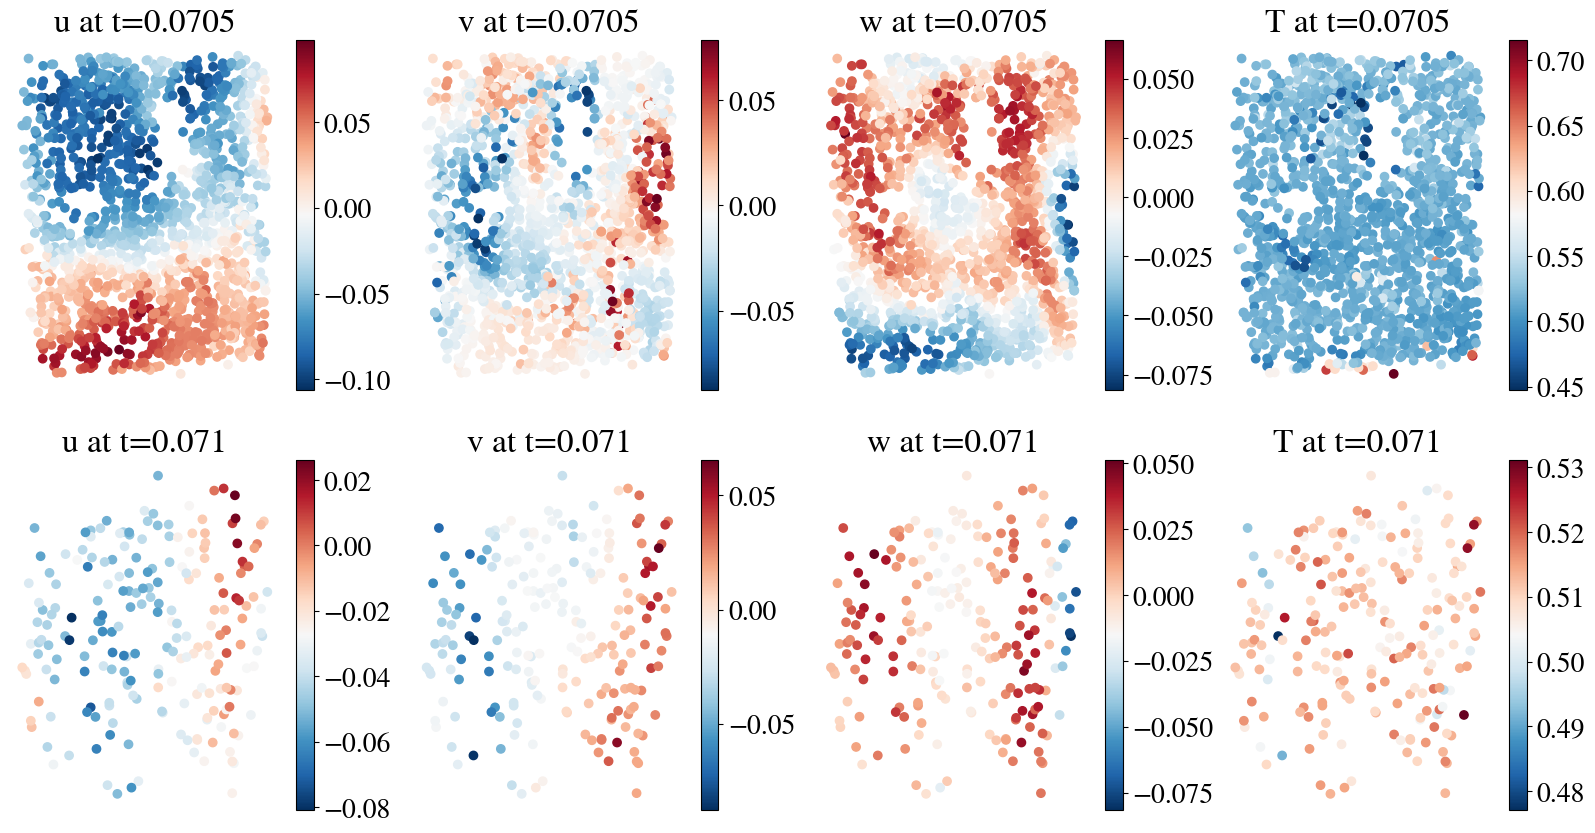

In [8]:
a = pd.read_hdf(data_path)
combined_data = np.array(a)
nan_rows = np.isnan(combined_data).any(axis=1)
combined_data = combined_data[~nan_rows]
print(combined_data.shape)
T=combined_data[:,0].flatten()[:,None]
X=combined_data[:,1].flatten()[:,None]
Y=combined_data[:,2].flatten()[:,None]
Z=combined_data[:,3].flatten()[:,None]
U=combined_data[:,4].flatten()[:,None]
V=combined_data[:,5].flatten()[:,None]
W=combined_data[:,6].flatten()[:,None]
theta=combined_data[:,8].flatten()[:,None]

X_all_0=np.hstack((T,X,Y,Z,U,V,W,theta))
X_star=np.hstack([T,X,Y,Z])
u_star=np.hstack([U,V,W,theta])
all_times=np.sort(np.unique(T))
indx_t=100

# %%
print(f'min values:{X_star.min(0)}')
print(f'max values:{X_star.max(0)}')
print(f'min values:{u_star.min(0)}')
print(f'max values:{u_star.max(0)}')

# %%
X_all=[]
for indx_t in tqdm.tqdm(range(len(all_times))):
    time_filter = X_all_0[:, 0] == all_times[indx_t]
    data_at_t=filter_Z(X_all_0[time_filter],row=4)
    data_at_t=filter_Z(data_at_t,row=5)
    data_at_t=filter_Z(data_at_t,row=6)
    data_at_t=filter_Magnitude(data_at_t,row=7,T_max=0.72,T_min=0.44)
    X_all.append(data_at_t)


# %%
indx_t=100
X_all=np.vstack(X_all)
for indx_t in tqdm.tqdm(range(1)):
    time_filter = X_all[:, 0] == all_times[indx_t]
    data_at_time = X_all[time_filter]

    # Extract U, V, W, and Theta for the specific time
    U = data_at_time[:, 4]
    V = data_at_time[:, 5]
    W = data_at_time[:, 6]
    Theta = data_at_time[:, 7]

    # Coordinates for plotting
    x_coord = data_at_time[:, 1]
    y_coord = data_at_time[:, 2]
    z_coord = data_at_time[:, 3]

    # Determine the midplane values for y and z
    y_midplane = np.median(y_coord)
    z_midplane = np.median(z_coord)

    # Define a small range (tolerance) for the midplane
    tolerance = 0.05  # Adjust this value as needed

    # Filtering data for y and z midplanes within the tolerance
    y_midplane_filter = np.abs(y_coord - y_midplane) <= tolerance
    z_midplane_filter = np.abs(z_coord - z_midplane) <= tolerance

    # Component names
    component_names = ['u', 'v', 'w', 'T']

    # Current time
    t = all_times[indx_t]
    name_image=result_path+f'Raw_at_t={t/len(all_times):.8f}.png'
    # Plotting
    fig = plt.figure(figsize=(20, 10))

    # Define colormap
    cmap = 'RdBu_r'

    # Plotting for midplane in z
    for i, comp in enumerate([U, V, W, Theta], start=1):
        ax = fig.add_subplot(2, 4, i)
        scatter = ax.scatter(x_coord[z_midplane_filter], y_coord[z_midplane_filter], c=comp[z_midplane_filter], cmap=cmap)
        ax.set_title(f'{component_names[i-1]} at t={t:.4f}')
        plt.axis('off')
        plt.colorbar(scatter)

    # Plotting for midplane in y
    for i, comp in enumerate([U, V, W, Theta], start=5):
        ax = fig.add_subplot(2, 4, i)
        scatter = ax.scatter(x_coord[y_midplane_filter], z_coord[y_midplane_filter], c=comp[y_midplane_filter], cmap=cmap)
        ax.set_title(f'{component_names[i-5]} at t={t:.3f}')
        plt.axis('off')
        plt.colorbar(scatter)

    plt.savefig(name_image)
    print('plot')

## BCs

In [9]:
# %%
X_star=X_all[:,0:4]
u_star=X_all[:,4:]
# Improved range calculation
lb, ub = np.min(X_star, axis=0), np.max(X_star, axis=0)
x_min, y_min = lb[0], lb[1]
x_max, y_max = ub[0], ub[1]
print(lb)
print(ub)
print(X_star.shape)

# Filter to get the data in the specified time window
time_filter = (X_all[:, 0] >= time_start) & (X_all[:, 0] <= time_final)
X_star_f= X_star[time_filter]
u_star_f = u_star[time_filter]
X_final=np.hstack([X_star_f,u_star_f])

lb, ub = np.min(X_star_f, axis=0), np.max(X_star_f, axis=0)
x_min, y_min = lb[0], lb[1]
x_max, y_max = ub[0], ub[1]
print(lb)
print(ub)
print(X_star_f.shape,u_star_f.shape)


# %%
# Given ranges for x, y, and z
t_list = np.linspace(lb[0], ub[0], 200).flatten()[:, None]
x_list = np.linspace(lb[1], ub[1], 100).flatten()[:, None]
y_list = np.linspace(0, 1, 100).flatten()[:, None]
z_list = np.linspace(lb[3], ub[3], 40).flatten()[:, None]

# Create 3D mesh
X_mesh, Y_mesh, Z_mesh = np.meshgrid(x_list.flatten(), y_list.flatten(), z_list.flatten(), indexing='ij')

# Printing shapes for verification
print(f"X_mesh shape: {X_mesh.shape}")
print(f"Y_mesh shape: {Y_mesh.shape}")
print(f"Z_mesh shape: {Z_mesh.shape}")
X_eval=np.hstack((X_mesh.flatten()[:, None],
                  Y_mesh.flatten()[:, None],
                  Z_mesh.flatten()[:, None],))

print(f"X_eval shape: {X_eval.shape}")


# %% [markdown]
# ## Extract Bcs

# %%
# Assuming X_eval is already defined as per your code snippet
t_list = np.linspace(lb[0], ub[0], 200).flatten()[:, None]
# Create boolean masks for the condition
mask_0 = X_eval[:, 1] == 0
mask_1 = X_eval[:, 1] == 1
# Split the data
X_bottom = X_eval[X_eval[:, 1] == 0]
X_top = X_eval[X_eval[:, 1] == 1]
X_BCs_T=[]
X_BCs_B=[]

for t_frame in tqdm.tqdm(t_list):
    X_BCs_T.append(np.hstack((X_top[:,0:1]*0+t_frame,X_top)))
    X_BCs_B.append(np.hstack((X_bottom[:,0:1]*0+t_frame,X_bottom)))
X_BCs_T=np.concatenate(X_BCs_T)
X_BCs_B=np.concatenate(X_BCs_B)
print(X_BCs_T.shape,X_BCs_B.shape)


[ 0.07053144 -0.61584576  0.01827458 -0.10085424]
[70.39037967  0.63734746  0.99108983  0.10135593]
(2828720, 4)
[10.01546484 -0.61530678  0.01921525 -0.10071864]
[29.97586309  0.63559492  0.99108983  0.10093542]
(840816, 4) (840816, 4)
X_mesh shape: (100, 100, 40)
Y_mesh shape: (100, 100, 40)
Z_mesh shape: (100, 100, 40)
X_eval shape: (400000, 3)


100%|██████████| 200/200 [00:00<00:00, 10608.96it/s]

(800000, 4) (800000, 4)


# Residual Points


In [10]:

# %%
print(lb)
print(ub)
X_r = lb + (ub-lb)*lhs(4,6* N_r//8)
print(X_r.shape)

ub1=[ub[0],ub[1],ub[2]/10,ub[3]]
lb1=np.copy(lb)
print(lb1)
print(ub1)
X_r1 = lb1 + (ub1-lb1)*lhs(4, 1* N_r//8)
print(X_r1.shape)

ub2=np.copy(ub)
lb2=[lb[0],lb[1],9*ub[2]/10,lb[3]]
print(lb2)
print(ub2)

X_r2 = lb2 + (ub2-lb2)*lhs(4, 1* N_r//8)
print(X_r2.shape)


# %% [markdown]
# ## Group Dataset
# 

# %%
X_res=np.vstack([X_r,X_r1,X_r2])
X_sol=np.hstack((X_star_f,u_star_f))
print(X_sol.shape)
unique_times=np.unique(X_sol[:,0:1])
frames = []  # List to store frames
# Loop over each unique time
for time_frame in tqdm.tqdm(unique_times):
    # Filter X_sol for the current time
    frame = X_sol[X_sol[:, 0] == time_frame]
    # Append the frame to the list
    frames.append(frame)


# %%
if train_ratio<=0.5:
    skip_frames = int(1 / train_ratio)
    idx_all_frames = np.arange(0, len(frames))
    idx_Train = np.arange(1, len(frames) - 1, skip_frames)
    idx_Train = np.append([0], idx_Train)  # Add the first frame
    idx_Train = np.append(idx_Train, [len(frames) - 1])  # Add the last frame
    idx_Test = np.setdiff1d(idx_all_frames, idx_Train)
    print(f'Skipping:{skip_frames}')
    print(f'Training on frames:{idx_Train}')
    print(f'Testing on frames:{idx_Test}')
    print(f'Training on {len(idx_Train)/len(frames)}')
else:
    idx_all_frames =np.arange(0,len(frames))
    np.random.seed(seed_np)
    idx_Train=np.random.choice(len(frames),int(len(frames)*train_ratio),replace=False)
    idx_Train = np.append([0], idx_Train)  # Add the first frame
    idx_Train = np.append(idx_Train, [len(frames) - 1])  # Add the last frame
    idx_Train = np.unique(idx_Train)
    idx_Test =np.setdiff1d(idx_all_frames,idx_Train)
    print(f'There are not enough frames to skip')
    print(f'Training on frames:{np.sort(idx_Train)}')
    print(f'Testing on frames:{idx_Test}')

# %%
X_train=np.zeros((1,X_sol.shape[1]))
for idx in tqdm.tqdm(idx_Train):
    X_train=np.vstack((X_train,frames[idx]))
X_train=X_train[1:]
X_test=np.zeros((1,X_sol.shape[1]))
for idx in tqdm.tqdm(idx_Test):
    X_test=np.vstack((X_test,frames[idx]))
X_test=X_test[1:]

# %%
#
num_points=150000
if len(X_test)<num_points:
    X_GT=np.copy(X_test)
else:
    np.random.seed(seed_np)   
    idx_Gt=np.random.choice(len(X_test),num_points,replace=False)
    X_GT=X_test[idx_Gt]

#Subsample BCs
np.random.seed(seed_np)
idx_bc_T=np.random.choice(len(X_BCs_T),N_b,replace=False)
np.random.seed(seed_np)
idx_bcs_B=np.random.choice(len(X_BCs_B),N_b,replace=False)
X_Top=X_BCs_T[idx_bc_T]
X_Bot=X_BCs_B[idx_bcs_B]

# Printing the shapes of the datasets for verification
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Test Eval set shape: {X_GT.shape}")
print(f"BCs Top shape: {X_Top.shape}")
print(f"Bcs Bottom set shape: {X_BCs_B.shape}")


[10.01546484 -0.61530678  0.01921525 -0.10071864]
[29.97586309  0.63559492  0.99108983  0.10093542]


(600000, 4)
[10.01546484 -0.61530678  0.01921525 -0.10071864]
[29.97586308582471, 0.6355949152542374, 0.09910898305084745, 0.10093542372881356]
(100000, 4)
[10.015464842793197, -0.615306779661017, 0.8919808474576272, -0.10071864406779661]
[29.97586309  0.63559492  0.99108983  0.10093542]
(100000, 4)
(840816, 8)


100%|██████████| 284/284 [00:01<00:00, 188.35it/s]


Skipping:2
Training on frames:[  0   1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33
  35  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69
  71  73  75  77  79  81  83  85  87  89  91  93  95  97  99 101 103 105
 107 109 111 113 115 117 119 121 123 125 127 129 131 133 135 137 139 141
 143 145 147 149 151 153 155 157 159 161 163 165 167 169 171 173 175 177
 179 181 183 185 187 189 191 193 195 197 199 201 203 205 207 209 211 213
 215 217 219 221 223 225 227 229 231 233 235 237 239 241 243 245 247 249
 251 253 255 257 259 261 263 265 267 269 271 273 275 277 279 281 283]
Testing on frames:[  2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36
  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72
  74  76  78  80  82  84  86  88  90  92  94  96  98 100 102 104 106 108
 110 112 114 116 118 120 122 124 126 128 130 132 134 136 138 140 142 144
 146 148 150 152 154 156 158 160 162 164 166 168 170 172 174 176 178 180
 182 1

100%|██████████| 141/141 [00:00<00:00, 911.78it/s] 


Training set shape: (423546, 8)
Test set shape: (417270, 8)
Test Eval set shape: (150000, 8)
BCs Top shape: (50000, 4)
Bcs Bottom set shape: (800000, 4)


# Select Tempertature

In [11]:

T_min=0.50
T_med=0.60
T_max=0.70
X_train_T_1=filter_Magnitude(X_train,row=7,T_max=1.00005*T_min,T_min=0.9995*T_min)
X_train_T_2=filter_Magnitude(X_train,row=7,T_max=1.00005*T_med,T_min=0.9995*T_med)
X_train_T_3=filter_Magnitude(X_train,row=7,T_max=1.00005*T_max,T_min=0.9995*T_max)
print(X_train_T_1.shape)
print(X_train_T_2.shape)
print(X_train_T_3.shape)
# Balance data
max_points=np.max((len(X_train_T_1),len(X_train_T_2),len(X_train_T_3)))
idx_1=np.random.choice(len(X_train_T_1),max_points)
idx_2=np.random.choice(len(X_train_T_2),max_points)
idx_3=np.random.choice(len(X_train_T_3),max_points)
X_train_T_1=X_train_T_1[idx_1]
X_train_T_2=X_train_T_2[idx_2]
X_train_T_3=X_train_T_3[idx_3]
X_train_T=np.vstack((X_train_T_1,X_train_T_2,X_train_T_3))
X_train_T=X_train
print(X_train_T_1.shape)
print(X_train_T_2.shape)
print(X_train_T_3.shape)
print(X_train_T.shape)
# Balance data

# %%
X_train_T=filter_Magnitude(X_train_T,row=2,T_max=0.9,T_min=0.1)
X_train=filter_Magnitude(X_train,row=2,T_max=0.9,T_min=0.1)
X_test=filter_Magnitude(X_test,row=2,T_max=0.9,T_min=0.1)
X_GT=filter_Magnitude(X_GT,row=2,T_max=0.9,T_min=0.1)
lb_res=X_res.min(0)
ub_res=X_res.max(0)
print(lb_res)
print(ub_res)
N_r=100000
X_res2 = lb + (ub-lb)*lhs(4, N_r)
X_res_low=filter_Magnitude(X_res2,row=2,T_max=0.1,T_min=0.0)
X_res_high=filter_Magnitude(X_res2,row=2,T_max=1.0,T_min=0.9)
print('Low res region',X_res_low.shape)
print(X_res_low.min(0))
print(X_res_low.max(0))
print('High res region',X_res_high.shape)
print(X_res_high.min(0))
print(X_res_high.max(0))
X_res=np.vstack((X_res,X_res_low,X_res_high))
print('All res region',X_res.shape)
print(X_res.min(0))
print(X_res.max(0))

# %% [markdown]

(1114, 8)
(62, 8)
(12, 8)
(1114, 8)
(1114, 8)
(1114, 8)
(423546, 8)
[10.01546646 -0.61530506  0.01921565 -0.10071861]
[29.97584736  0.63559487  0.99108959  0.10093516]
Low res region (8313, 4)
[10.0156657  -0.61525749  0.01921632 -0.10071431]
[29.97318706  0.63522577  0.09999758  0.10090679]
High res region (9373, 4)
[10.01609291 -0.61525152  0.90000556 -0.10067529]
[29.97483037  0.63533777  0.99108342  0.10092405]
All res region (817686, 4)
[10.01546646 -0.61530506  0.01921565 -0.10071861]
[29.97584736  0.63559487  0.99108959  0.10093516]


## Data Analytics

In [12]:
# %%
print(f'Bounds for Data Train with {X_train.shape} points:')
print(np.min(X_train,axis=0))
print(np.max(X_train,axis=0))
print(f'Bounds for Data Train T with {X_train_T.shape} points:')
print(np.min(X_train_T,axis=0))
print(np.max(X_train_T,axis=0))
print(f'Bounds for Data Test with {X_test.shape} points:')
print(np.min(X_test,axis=0))
print(np.max(X_test,axis=0))
print(f'Bounds for Data Eval with {X_GT.shape} points:')
print(np.min(X_GT,axis=0))
print(np.max(X_GT,axis=0))  
print(f'Bounds for Residual Data with {X_res.shape} points:')
print(np.min(X_res,axis=0))
print(np.max(X_res,axis=0))
print(f'Bounds for Top BCs Data with {X_Top.shape} points:')
print(np.min(X_Top,axis=0))
print(np.max(X_Top,axis=0))
print(f'Bounds for Bottom BCs Data with {X_Bot.shape} points:')
print(np.min(X_Bot,axis=0))
print(np.max(X_Bot,axis=0))

# %%
dataset = {
    'Data': X_train,
    'Data_T': X_train_T,
    'Bcs_T': X_Top,
    'Bcs_B': X_Bot,
    'Test': X_test,
    'Res': X_res,
    'GT': X_GT
}
lam = {
    'Data': 1000,
    'Data_T': 10,
    'Bcs_T': 10,
    'Bcs_B': 10,
    'Test': 1,
    'Res': 1,
    'GT': 1,
    'Mx': 1e-10,
    'My': 1e-10,
    'Mz':1e-10,
    'Mass':1,
    'MT':1e-10,
}
neq = {
    'Data': 3,
    'Data_T': 1,
    'Bcs_T': 4,
    'Bcs_B': 4,
    'Test': 1,
    'Res': 8,
    'GT': 1
}



Bounds for Data Train with (381955, 8) points:
[10.01546484 -0.61530678  0.10000508 -0.10068661 -0.15066165 -0.10709266
 -0.11128795  0.44038885]
[29.97586309  0.63559492  0.89999492  0.10037068  0.14506438  0.13526639
  0.11564086  0.71995009]
Bounds for Data Train T with (381955, 8) points:
[10.01546484 -0.61530678  0.10000508 -0.10068661 -0.15066165 -0.10709266
 -0.11128795  0.44038885]
[29.97586309  0.63559492  0.89999492  0.10037068  0.14506438  0.13526639
  0.11564086  0.71995009]
Bounds for Data Test with (376519, 8) points:
[10.15652773 -0.61414915  0.10000339 -0.10071864 -0.15140789 -0.10668008
 -0.10878694  0.44038478]
[29.90533164  0.63332203  0.89999831  0.10084373  0.14794536  0.13455819
  0.11220858  0.71820317]
Bounds for Data Eval with (135140, 8) points:
[10.15652773 -0.61314746  0.10000678 -0.09947576 -0.15140789 -0.10668008
 -0.10792397  0.44263252]
[29.90533164  0.62943729  0.89998814  0.10042729  0.14208958  0.13305791
  0.10884271  0.7167673 ]
Bounds for Residual 

143


  0%|          | 0/1 [00:00<?, ?it/s]

[11.35556225 -0.60389831  0.10002034 -0.09616864 -0.10571385 -0.1011322
 -0.07807582  0.44553932]
[11.35556225  0.61491525  0.89972373  0.09444153  0.11576586  0.11777348
  0.1049988   0.65104327]


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

plot


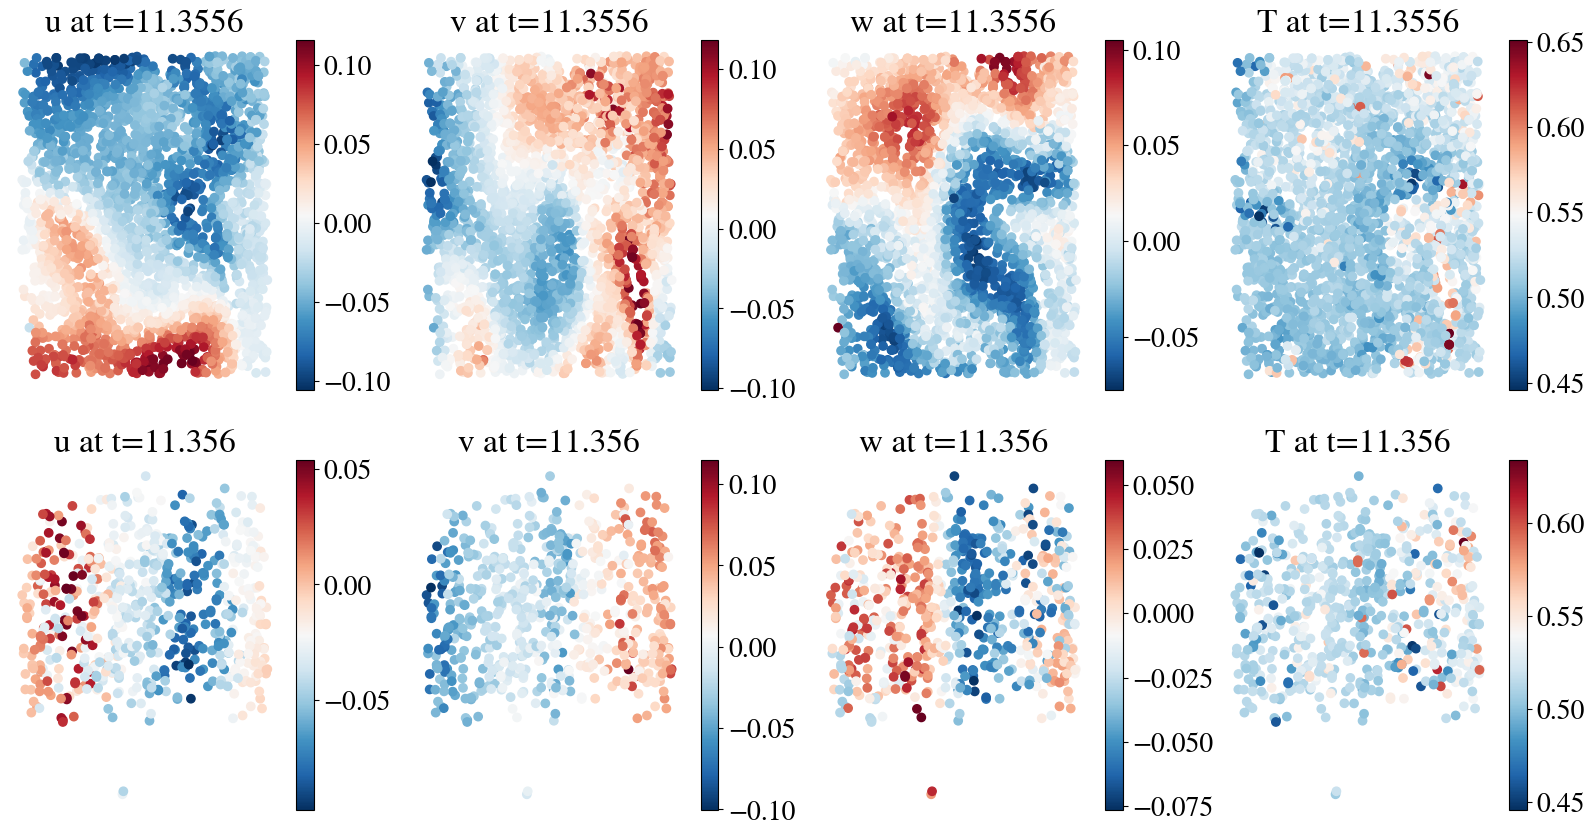

In [13]:

# %%
all_times=np.sort(np.unique(X_train[:,0]))
print(len(all_times))
start=10
end=start+1

for indx_t in tqdm.tqdm(range(start,end)):
    time_filter = X_train[:, 0] == all_times[indx_t]
    data_at_time = X_train[time_filter]
    print(data_at_time.min(0))
    print(data_at_time.max(0))


    # Extract U, V, W, and Theta for the specific time
    U = data_at_time[:, 4]
    V = data_at_time[:, 5]
    W = data_at_time[:, 6]
    Theta = data_at_time[:, 7]

    # Coordinates for plotting
    x_coord = data_at_time[:, 1]
    y_coord = data_at_time[:, 2]
    z_coord = data_at_time[:, 3]

    # Determine the midplane values for y and z
    y_midplane = np.median(y_coord)
    z_midplane = np.median(z_coord)

    # Define a small range (tolerance) for the midplane
    tolerance = 0.1  # Adjust this value as needed

    # Filtering data for y and z midplanes within the tolerance
    y_midplane_filter = np.abs(y_coord - y_midplane) <= tolerance
    z_midplane_filter = np.abs(z_coord - z_midplane) <= tolerance

    # Component names
    component_names = ['u', 'v', 'w', 'T']

    # Current time
    t = all_times[indx_t]
    name_image=result_path+f'Raw_at_t={t/len(all_times):.8f}.png'
    # Plotting
    fig = plt.figure(figsize=(20, 10))

    # Define colormap
    cmap = 'RdBu_r'

    # Plotting for midplane in z
    for i, comp in enumerate([U, V, W, Theta], start=1):
        ax = fig.add_subplot(2, 4, i)
        scatter = ax.scatter(x_coord[z_midplane_filter], y_coord[z_midplane_filter], c=comp[z_midplane_filter], cmap=cmap)
        ax.set_title(f'{component_names[i-1]} at t={t:.4f}')
        plt.axis('off')
        plt.colorbar(scatter)

    # Plotting for midplane in y
    for i, comp in enumerate([U, V, W, Theta], start=5):
        ax = fig.add_subplot(2, 4, i)
        scatter = ax.scatter(x_coord[y_midplane_filter], z_coord[y_midplane_filter], c=comp[y_midplane_filter], cmap=cmap)
        ax.set_title(f'{component_names[i-5]} at t={t:.3f}')
        plt.axis('off')
        plt.colorbar(scatter)

    plt.savefig(name_image)
    print('plot')


# %% [markdown]

 # RBA_Weights

Lenght of Data dataset: 381955
Lenght of Data_T dataset: 381955
Lenght of Bcs_T dataset: 50000
Lenght of Bcs_B dataset: 50000
Lenght of Test dataset: 376519
Lenght of Res dataset: 817686
Lenght of GT dataset: 135140
Batch size for Data dataset: 5000
Batch size for Data_T dataset: 5000
Batch size for Bcs_T dataset: 5000
Batch size for Bcs_B dataset: 5000
Batch size for Res dataset: 5000
Lambda shape for Data dataset: (381955, 3)
Lambda shape for Data_T dataset: (381955, 1)
Lambda shape for Bcs_T dataset: (50000, 4)
Lambda shape for Bcs_B dataset: (50000, 4)
Lambda shape for Test dataset: (376519, 1)
Lambda shape for Res dataset: (817686, 8)
Lambda shape for GT dataset: (135140, 1)


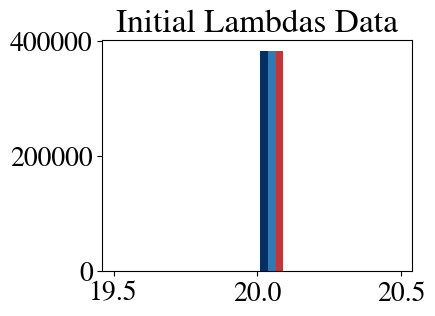

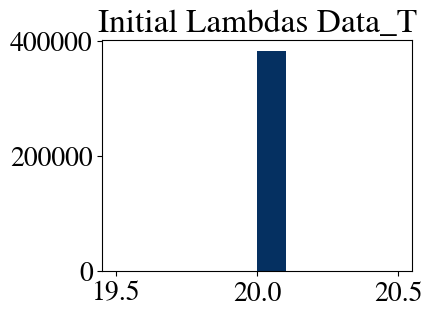

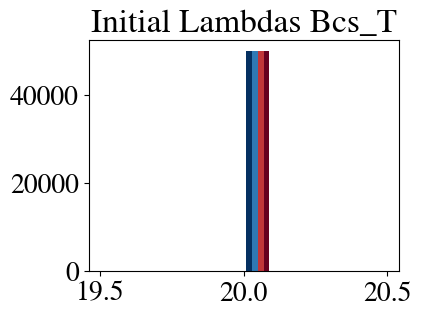

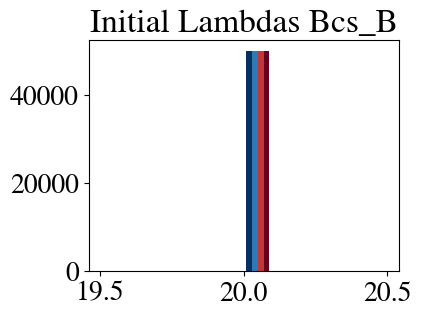

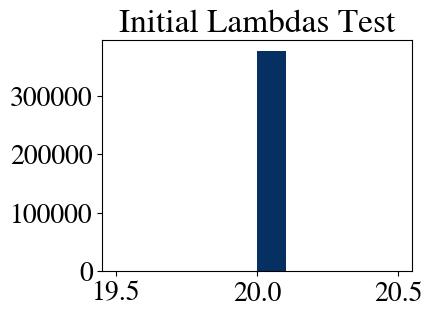

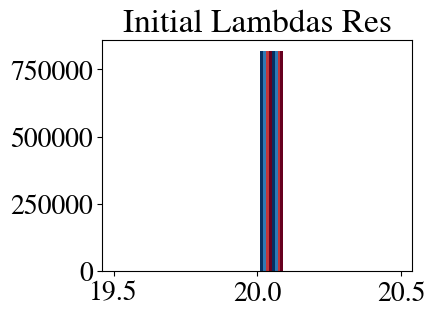

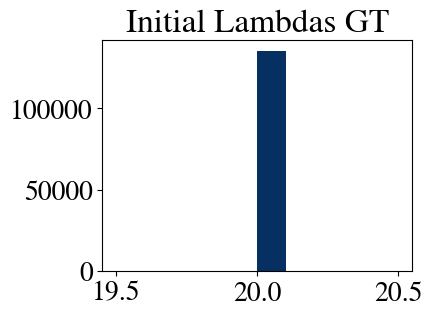

In [14]:
# %%
lenghts=[]
for key in dataset.keys():
    lenghts.append(len(dataset[key]))
    print(f'Lenght of {key} dataset: {len(dataset[key])}')
N_train=int(np.max(lenghts))
if batch_size<0:
    batch_size=N_train
All_its=int(np.ceil(N_train/batch_size))
BATCH_SIZES = {}


for key in dataset.keys():
    if not(key == 'GT' or key == 'Test'):
        BATCH_SIZES[key] = int(np.ceil(len(dataset[key]) / All_its))
        if args.Equal_Batch:
            if len(dataset[key])>=batch_size:
                BATCH_SIZES[key]=batch_size
            else:
                BATCH_SIZES[key]=len(dataset[key])
        print(f'Batch size for {key} dataset: {BATCH_SIZES[key]}')
    

lambdas={}
for key in dataset.keys():
    np.random.seed(seed_np)
    lambdas[key] = np.random.uniform(0, 1, size=(len(dataset[key]), neq[key]))
    if init_zero:
        lambdas[key]= lambdas[key]*0+max_lambda/5
    print(f'Lambda shape for {key} dataset: {lambdas[key].shape}')



# %%
for key in dataset.keys():

    fig, ax = plt.subplots(figsize =(4, 3))
    ax.hist(lambdas[key])
    ax.set_title(f"Initial Lambdas {key}")
         

# Loss Functions





%% [markdown]


%% [markdown]
Let $A=[P,0,R]$

\begin{align*}
(\nabla\times A)_i&=\epsilon_{ijk}\left(\frac{\partial}{\partial x_j}A_k\right)\\
(\nabla\times A)_1=u&=\frac{\partial}{\partial x_2}A_3-\frac{\partial}{\partial x_3}A_2=R_y\\
(\nabla\times A)_2=v&=\frac{\partial}{\partial x_3}A_1-\frac{\partial}{\partial x_1}A_3=P_z-R_x\\
(\nabla\times A)_3=w&=\frac{\partial}{\partial x_1}A_2-\frac{\partial}{\partial x_2}A_1=-P_y\\
\end{align*}

\begin{align*}
a&=w_y-v_z\\
b&=u_z-w_x\\
c&=v_x-u_y\\
e_1&=a_t+ua_x+va_y+wa_z-(au_x+bu_y+cu_z+\left(\frac{Pr}{Ra}\right)^{1/2}(a_{xx}+a_{yy}+a_{zz})+\theta_z)\\
e_2&=b_t+ub_x+vb_y+wb_z-(av_x+bv_y+cv_z+\left(\frac{Pr}{Ra}\right)^{1/2}(b_{xx}+b_{yy}+b_{zz}))\\
e_3&=c_t+uc_x+vc_y+wc_z-(aw_x+bw_y+cw_z+\left(\frac{Pr}{Ra}\right)^{1/2}(c_{xx}+c_{yy}+c_{zz})-\theta_x)\\
e_4&=(\theta_t+u\theta_x+v\theta_y+w\theta_z-\left(\frac{1}{PrRa}\right)^{1/2}(\theta_{xx}+\theta_{yy}+\theta_{zz}))\\
e_5&=u_x+v_y+w_z
\end{align*}


We also know that $\nabla^2 u+\nabla\times \omega=0$. Recall that $\omega=[a,b,c]$

\begin{align*}
(\nabla\times \omega)_i&=\epsilon_{ijk}\left(\frac{\partial}{\partial x_j}\omega_k\right)\\
(\nabla\times \omega)_1&=\frac{\partial}{\partial x_2}\omega_3-\frac{\partial}{\partial x_3}\omega_2=c_y-b_z\\
(\nabla\times \omega)_2&=\frac{\partial}{\partial x_3}\omega_1-\frac{\partial}{\partial x_1}\omega_3=a_z-c_x\\
(\nabla\times \omega)_3&=\frac{\partial}{\partial x_1}\omega_2-\frac{\partial}{\partial x_2}\omega_1=b_x-a_y\\
\end{align*}

So our final equations would be:
\begin{align*}
e_6&=c_y-b_z+(u_{xx}+u_{yy}+u_{zz})\\
e_7&=a_z-c_x+(v_{xx}+v_{yy}+v_{zz})\\
e_8&=b_x-a_y+(w_{xx}+w_{yy}+w_{zz})\\
\end{align*}



In [15]:

# %%
scale_p=1
Ra=Raf
sqrt_Pr_over_Ra=jnp.sqrt(Pr/Ra)
sqrt_1_over_PrRa=jnp.sqrt(1/(Pr*Ra))
print('sqrt_Pr_over_Ra,Re_eq=',sqrt_Pr_over_Ra,1/sqrt_Pr_over_Ra)
print('sqrt_1_over_PrRa,Re_eq=',sqrt_1_over_PrRa,1/sqrt_1_over_PrRa)
U=0.3
um=U/2
vm=U/2
wm=U/2
Tm=0.5
beta=5
alpha=0.1
Y_max=1.0
def Rayleight_Bernard_eq(params,Ra):
    alpha,beta,params_NN=params
    nu_1=jnp.sqrt(Pr/Ra)
    nu_2=jnp.sqrt(1/(Pr*Ra))
    """
    input = (x, y)
    output = (u, v, p,T)
    sqrt_Pr_Ra
    sqrt_RaPr
    """
    # Neural Network
    phi_T = lambda x: (x[2])*(Y_max-x[2])/0.25#normalize it
    g_T =lambda x: - x[2]+1.0# base solution
    fn={
        "uvwT" :lambda x: pinn_fn(params_NN["uvwT"], x, M1, M2,activation_fn,norm_fn),
    }

    u, v,w,T = (
                 lambda x: u_scale*fn["uvwT"](x)[0], 
                 lambda x: v_scale*fn["uvwT"](x)[1], 
                 lambda x: w_scale*fn["uvwT"](x)[2], 
                 lambda x: g_T(x)+T_scale*phi_T(x)*fn["uvwT"](x)[3],
                 )
   # derivatives
    def derivative_fn(f, x, idx):
        """Computes df/dx[idx] using forward mode AD."""
        perturbation = jnp.zeros_like(x)
        perturbation = perturbation.at[idx].set(1.0)
        primals, tangents = jvp(f, (x,), (perturbation,))
        return tangents
    u_x = lambda x: derivative_fn(u, x, 1)
    u_y = lambda x: derivative_fn(u, x, 2)
    u_z = lambda x: derivative_fn(u, x, 3)

    u_xx = lambda x: derivative_fn(u_x, x, 1)
    u_yy = lambda x: derivative_fn(u_y, x, 2)
    u_zz = lambda x: derivative_fn(u_z, x, 3)

    v_x = lambda x: derivative_fn(v, x, 1)
    v_y = lambda x: derivative_fn(v, x, 2)
    v_z = lambda x: derivative_fn(v, x, 3)

    v_xx = lambda x: derivative_fn(v_x, x, 1)
    v_yy = lambda x: derivative_fn(v_y, x, 2)
    v_zz = lambda x: derivative_fn(v_z, x, 3)

    w_x = lambda x: derivative_fn(w, x, 1)
    w_y = lambda x: derivative_fn(w, x, 2)
    w_z = lambda x: derivative_fn(w, x, 3)

    w_xx = lambda x: derivative_fn(w_x, x, 1)
    w_yy = lambda x: derivative_fn(w_y, x, 2)
    w_zz = lambda x: derivative_fn(w_z, x, 3)

    T_t = lambda x: derivative_fn(T, x, 0)
    T_x = lambda x: derivative_fn(T, x, 1)
    T_y = lambda x: derivative_fn(T, x, 2)
    T_z = lambda x: derivative_fn(T, x, 3)

    T_xx = lambda x: derivative_fn(T_x, x, 1)
    T_yy = lambda x: derivative_fn(T_y, x, 2)
    T_zz = lambda x: derivative_fn(T_z, x, 3)
    #vorticity:
    a=lambda x: w_y(x)-v_z(x)
    b=lambda x: u_z(x)-w_x(x)
    c=lambda x: v_x(x)-u_y(x)
    #Vorticity in x Omega_x=a
    a_t = lambda x: derivative_fn(a, x, 0)
    a_x = lambda x: derivative_fn(a, x, 1)
    a_y = lambda x: derivative_fn(a, x, 2)
    a_z = lambda x: derivative_fn(a, x, 3)
    a_xx = lambda x: derivative_fn(a_x, x, 1)
    a_yy = lambda x: derivative_fn(a_y, x, 2)
    a_zz = lambda x: derivative_fn(a_z, x, 3)
    #Vorticity in y Omega_y=b
    b_t = lambda x: derivative_fn(b, x, 0)
    b_x = lambda x: derivative_fn(b, x, 1)
    b_y = lambda x: derivative_fn(b, x, 2)
    b_z = lambda x: derivative_fn(b, x, 3)
    b_xx = lambda x: derivative_fn(b_x, x, 1)
    b_yy = lambda x: derivative_fn(b_y, x, 2)
    b_zz = lambda x: derivative_fn(b_z, x, 3)
    #Vorticity in z Omega_z=c
    c_t = lambda x: derivative_fn(c, x, 0)
    c_x = lambda x: derivative_fn(c, x, 1)
    c_y = lambda x: derivative_fn(c, x, 2)
    c_z = lambda x: derivative_fn(c, x, 3)
    c_xx = lambda x: derivative_fn(c_x, x, 1)
    c_yy = lambda x: derivative_fn(c_y, x, 2)
    c_zz = lambda x: derivative_fn(c_z, x, 3)
    # equations
    eq1 = (
        lambda x: (
                a_t(x)+ (u(x) * a_x(x) + v(x) * a_y(x) + w(x) * a_z(x))
                -       (a(x) * u_x(x) + b(x) * u_y(x) + c(x) * u_z(x))
                -  (nu_1)* (a_xx(x) + a_yy(x)+a_zz(x))
                +  T_z(x))
                )
    eq2 = (
        lambda x: (
                b_t(x)+ (u(x) * b_x(x) + v(x) * b_y(x)+ w(x) * b_z(x))
                -       (a(x) * v_x(x) + b(x) * v_y(x)+ c(x) * v_z(x))
                -  (nu_1) * (b_xx(x) + b_yy(x)+b_zz(x))
    ))
    eq3 = (
        lambda x: (
                c_t(x)+ (u(x) * c_x(x) + v(x) * c_y(x) + w(x) * c_z(x))
                -       (a(x) * w_x(x) + b(x) * w_y(x) + c(x) * w_z(x))
                -  (nu_1)* (c_xx(x) + c_yy(x)+c_zz(x))
                -  T_x(x))
                )
    eq4 = (
        lambda x: (u_x(x)+v_y(x)+w_z(x))
                )
    eq5 = (
        lambda x: (
                 T_t(x) + (u(x) * T_x(x) + v(x) * T_y(x)+w(x)*T_z(x))
                -  (nu_2)* (T_xx(x) + T_yy(x)+ T_zz(x)))
                )
    eq6 = (
        lambda x: (c_y(x)-b_z(x)+(u_xx(x)+u_yy(x)+u_zz(x)))
                )
    eq7 = (
        lambda x: (a_z(x)-c_x(x)+(v_xx(x)+v_yy(x)+v_zz(x)))
                )
    eq8 = (
        lambda x: (b_x(x)-a_y(x)+(w_xx(x)+w_yy(x)+w_zz(x)))
                )
    return eq1, eq2,eq3,eq4,eq5,eq6,eq7,eq8


# %%
def u_PINN(params):
    alpha,beta,params_NN=params
    nu_1=jnp.sqrt(Pr/Ra)
    nu_2=jnp.sqrt(1/(Pr*Ra))
    """
    input = (x, y)
    output = (u, v, p,T)
    sqrt_Pr_Ra
    sqrt_RaPr
    """
    # Neural Network
    phi_T = lambda x: (x[2])*(Y_max-x[2])/0.25#normalize it
    g_T =lambda x: - x[2]+1.0# base solution
    fn={
        "uvwT" :lambda x: pinn_fn(params_NN["uvwT"], x, M1, M2,activation_fn,norm_fn),
    }

    u, v,w,T = (
                 lambda x: u_scale*fn["uvwT"](x)[0], 
                 lambda x: v_scale*fn["uvwT"](x)[1], 
                 lambda x: w_scale*fn["uvwT"](x)[2], 
                 lambda x: g_T(x)+T_scale*phi_T(x)*fn["uvwT"](x)[3],
                 )
   # derivatives
    def derivative_fn(f, x, idx):
        """Computes df/dx[idx] using forward mode AD."""
        perturbation = jnp.zeros_like(x)
        perturbation = perturbation.at[idx].set(1.0)
        primals, tangents = jvp(f, (x,), (perturbation,))
        return tangents
    u_x = lambda x: derivative_fn(u, x, 1)
    u_y = lambda x: derivative_fn(u, x, 2)
    u_z = lambda x: derivative_fn(u, x, 3)

    v_x = lambda x: derivative_fn(v, x, 1)
    v_y = lambda x: derivative_fn(v, x, 2)
    v_z = lambda x: derivative_fn(v, x, 3)

    w_x = lambda x: derivative_fn(w, x, 1)
    w_y = lambda x: derivative_fn(w, x, 2)
    w_z = lambda x: derivative_fn(w, x, 3)
    #vorticity:
    a=lambda x: w_y(x)-v_z(x)
    b=lambda x: u_z(x)-w_x(x)
    c=lambda x: v_x(x)-u_y(x)
    Omega=lambda x: jnp.sqrt(a(x)**2+b(x)**2+c(x)**2)
    return u, v,w, b , T   
u_model=u_PINN
PDE_eq= Rayleight_Bernard_eq


sqrt_Pr_over_Ra,Re_eq= 0.0005530663 1808.1014
sqrt_1_over_PrRa,Re_eq= 5.317945e-05 18804.256


## Training

In [16]:

@jit
def update_L2(params, lambdas,lam,Ra, opt_state, dataset: Dict[str, np.ndarray], batch_indices: Dict[str, np.ndarray]):
    # Compute the predictions based on the given functions.
    def compute_prediction(X, funcs):
        result = jnp.zeros((X.shape[0], len(funcs)))
        for i, fn in enumerate(funcs):
            result = result.at[:, i].set(vmap(fn, (0))(X[:, :layers_1[0]]).flatten())
        return result
    def loss_fn(params):
        # eqn error
        eq1, eq2,eq3,eq4,eq5,eq6,eq7,eq8= PDE_eq(params,Ra)
        u_fx, v_fx,w_fx, Omega_y_fx , T_fx     = u_model(params)

        # Adaptive NS residuals and Lambdas computation
        eq_pred   =compute_prediction(dataset['Res'], [eq1, eq2,eq3,eq4,eq5,eq6,eq7,eq8])
        r_eq = jnp.abs(eq_pred)

        lam_res = (gamma) * lambdas['Res'][batch_indices['Res']] + lr_lambdas_0 * r_eq / jnp.max(r_eq, axis=0)
        lambdas['Res'] = lambdas['Res'].at[batch_indices['Res']].set(lam_res)
        lam_res = lam_res*use_RBA+1
    
        # DataT
        pred_data_T    =compute_prediction(dataset['Data_T'], [T_fx ])
        r_pred_data_T  = jnp.abs(pred_data_T -0.5)
    
        lam_data_T = (gamma) * lambdas['Data_T'][batch_indices['Data_T']] + lr_lambdas_0 * r_pred_data_T  / jnp.max(r_pred_data_T , axis=0)
        lambdas['Data_T'] = lambdas['Data_T'].at[batch_indices['Data_T']].set(lam_data_T )
        lam_data_T  = lam_data_T *use_RBA+1
        # Data
        pred_data   =compute_prediction(dataset['Data'], [u_fx, v_fx,w_fx ])
        r_pred_data = jnp.abs(pred_data-dataset['Data'][:,4:7])
    
        lam_data = (gamma) * lambdas['Data'][batch_indices['Data']] + lr_lambdas_0 * r_pred_data / jnp.max(r_pred_data, axis=0)
        lambdas['Data'] = lambdas['Data'].at[batch_indices['Data']].set(lam_data)
        lam_data = lam_data*use_RBA+1

        # BCs Bot
        pred_bcb   =compute_prediction(dataset['Bcs_B'], [u_fx, v_fx,w_fx,Omega_y_fx ])
        r_pred_bcb= jnp.abs(pred_bcb)
    
        lam_bcb = (gamma) * lambdas['Bcs_B'][batch_indices['Bcs_B']] + lr_lambdas_0 * r_pred_bcb / jnp.max(r_pred_bcb, axis=0)
        lambdas['Bcs_B'] = lambdas['Bcs_B'].at[batch_indices['Bcs_B']].set(lam_bcb)
        lam_bcb = lam_bcb*use_RBA+1
    
        # BCs Top
        pred_bct   =compute_prediction(dataset['Bcs_T'], [u_fx, v_fx,w_fx,Omega_y_fx ])
        r_pred_bct= jnp.abs(pred_bct)
    
        lam_bct = (gamma) * lambdas['Bcs_T'][batch_indices['Bcs_T']] + lr_lambdas_0 * r_pred_bct / jnp.max(r_pred_bct, axis=0)
        lambdas['Bcs_T'] = lambdas['Bcs_T'].at[batch_indices['Bcs_T']].set(lam_bct)
        lam_bct = lam_bct*use_RBA+1

        
        loss_vals = {
            'Mx':  lam['Mx']*MSE(r_eq[:, 0:1], 0.0, weight=lam_res[:, 0:1]),
            'My':  lam['My']*MSE(r_eq[:, 1:2], 0.0, weight=lam_res[:, 1:2]),
            'Mz':  lam['Mz']*MSE(r_eq[:, 2:3], 0.0, weight=lam_res[:, 2:3]),
            'Mass':lam['Mass']*MSE(r_eq[:, 3:4], 0.0, weight=lam_res[:, 3:4]),
            'MT':  lam['MT']*MSE(r_eq[:, 4:5], 0.0, weight=lam_res[:, 4:5]),
            'Omega_x':lam['Mass']*MSE(r_eq[:, 5:6], 0.0, weight=lam_res[:, 5:6]),
            'Omega_y':lam['Mass']*MSE(r_eq[:, 6:7], 0.0, weight=lam_res[:, 6:7]),
            'Omega_z':lam['Mass']*MSE(r_eq[:, 7:8], 0.0, weight=lam_res[:, 7:8]),
            'Data_u':lam['Data']*MSE(r_pred_data[:, 0:1], 0.0, weight=lam_data[:, 0:1]),
            'Data_v':10*lam['Data']*MSE(r_pred_data[:, 1:2], 0.0, weight=lam_data[:, 1:2]),
            'Data_w':10*lam['Data']*MSE(r_pred_data[:, 2:3], 0.0, weight=lam_data[:, 2:3]),
            'Data_T':lam['Data_T']*MSE(r_pred_data_T, 0.0, weight=lam_data_T),
            'Bcs_B':lam['Bcs_B']*MSE(r_pred_bcb, 0.0, weight=lam_bcb),
            'Bcs_T':lam['Bcs_T']*MSE(r_pred_bct, 0.0, weight=lam_bct),
        }
        Error_vals = {
            'Mx':  jnp.mean(r_eq[:, 0:1]),
            'My':  jnp.mean(r_eq[:, 1:2]),
            'Mz':  jnp.mean(r_eq[:, 2:3]),
            'Mass':jnp.mean(r_eq[:, 3:4]),
            'MT':  jnp.mean(r_eq[:, 4:5]),
            'Omega_x':jnp.mean(r_eq[:, 5:6]),
            'Omega_y':jnp.mean(r_eq[:, 6:7]),
            'Omega_z':jnp.mean(r_eq[:, 7:8]),
            'Data_u':jnp.mean(r_pred_data[:, 0:1]),
            'Data_v':jnp.mean(r_pred_data[:, 1:2]),
            'Data_w':jnp.mean(r_pred_data[:, 2:3]),
            'Data_T':jnp.mean(r_pred_data_T),
            'Bcs_B':jnp.mean(r_pred_bcb),
            'Bcs_T':jnp.mean(r_pred_bct),
        }
        # Total Loss
        total_loss = sum(loss_vals.values())

        return total_loss, (Error_vals, lambdas)

    # Compute gradients of the loss function with respect to parameters.
    grad_fn = value_and_grad(loss_fn, has_aux=True)
    (_, loss_dict_and_lambdas), grads = grad_fn(params)
    losses_dict = loss_dict_and_lambdas[0]
    updated_lambdas = loss_dict_and_lambdas[1]

    # Update model parameters based on the calculated gradients.
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    return params, updated_lambdas, opt_state, losses_dict



In [17]:
@jit
def update_L1(params, lambdas,lam,Ra, opt_state, dataset: Dict[str, np.ndarray], batch_indices: Dict[str, np.ndarray]):
    # Compute the predictions based on the given functions.
    def compute_prediction(X, funcs):
        result = jnp.zeros((X.shape[0], len(funcs)))
        for i, fn in enumerate(funcs):
            result = result.at[:, i].set(vmap(fn, (0))(X[:, :layers_1[0]]).flatten())
        return result
    def loss_fn(params):
        # eqn error
        eq1, eq2,eq3,eq4,eq5,eq6,eq7,eq8= PDE_eq(params,Ra)
        u_fx, v_fx,w_fx, Omega_y_fx , T_fx     = u_model(params)

        # Adaptive NS residuals and Lambdas computation
        eq_pred   =compute_prediction(dataset['Res'], [eq1, eq2,eq3,eq4,eq5,eq6,eq7,eq8])
        r_eq = jnp.abs(eq_pred)

        lam_res = (gamma) * lambdas['Res'][batch_indices['Res']] + lr_lambdas_0 * r_eq / jnp.max(r_eq, axis=0)
        lambdas['Res'] = lambdas['Res'].at[batch_indices['Res']].set(lam_res)
        lam_res = lam_res*use_RBA+1
    
        # DataT
        pred_data_T    =compute_prediction(dataset['Data_T'], [T_fx ])
        r_pred_data_T  = jnp.abs(pred_data_T -0.5)
    
        lam_data_T = (gamma) * lambdas['Data_T'][batch_indices['Data_T']] + lr_lambdas_0 * r_pred_data_T  / jnp.max(r_pred_data_T , axis=0)
        lambdas['Data_T'] = lambdas['Data_T'].at[batch_indices['Data_T']].set(lam_data_T )
        lam_data_T  = lam_data_T *use_RBA+1
        # Data
        pred_data   =compute_prediction(dataset['Data'], [u_fx, v_fx,w_fx ])
        r_pred_data = jnp.abs(pred_data-dataset['Data'][:,4:7])
    
        lam_data = (gamma) * lambdas['Data'][batch_indices['Data']] + lr_lambdas_0 * r_pred_data / jnp.max(r_pred_data, axis=0)
        lambdas['Data'] = lambdas['Data'].at[batch_indices['Data']].set(lam_data)
        lam_data = lam_data*use_RBA+1

        # BCs Bot
        pred_bcb   =compute_prediction(dataset['Bcs_B'], [u_fx, v_fx,w_fx,Omega_y_fx ])
        r_pred_bcb= jnp.abs(pred_bcb)
    
        lam_bcb = (gamma) * lambdas['Bcs_B'][batch_indices['Bcs_B']] + lr_lambdas_0 * r_pred_bcb / jnp.max(r_pred_bcb, axis=0)
        lambdas['Bcs_B'] = lambdas['Bcs_B'].at[batch_indices['Bcs_B']].set(lam_bcb)
        lam_bcb = lam_bcb*use_RBA+1
    
        # BCs Top
        pred_bct   =compute_prediction(dataset['Bcs_T'], [u_fx, v_fx,w_fx,Omega_y_fx ])
        r_pred_bct= jnp.abs(pred_bct)
    
        lam_bct = (gamma) * lambdas['Bcs_T'][batch_indices['Bcs_T']] + lr_lambdas_0 * r_pred_bct / jnp.max(r_pred_bct, axis=0)
        lambdas['Bcs_T'] = lambdas['Bcs_T'].at[batch_indices['Bcs_T']].set(lam_bct)
        lam_bct = lam_bct*use_RBA+1

        
        loss_vals = {
            'Mx':  lam['Mx']*MAE(r_eq[:, 0:1], 0.0, weight=lam_res[:, 0:1]),
            'My':  lam['My']*MAE(r_eq[:, 1:2], 0.0, weight=lam_res[:, 1:2]),
            'Mz':  lam['Mz']*MAE(r_eq[:, 2:3], 0.0, weight=lam_res[:, 2:3]),
            'Mass':lam['Mass']*MAE(r_eq[:, 3:4], 0.0, weight=lam_res[:, 3:4]),
            'MT':  lam['MT']*MAE(r_eq[:, 4:5], 0.0, weight=lam_res[:, 4:5]),
            'Omega_x':lam['Mass']*MAE(r_eq[:, 5:6], 0.0, weight=lam_res[:, 5:6]),
            'Omega_y':lam['Mass']*MAE(r_eq[:, 6:7], 0.0, weight=lam_res[:, 6:7]),
            'Omega_z':lam['Mass']*MAE(r_eq[:, 7:8], 0.0, weight=lam_res[:, 7:8]),
            'Data_u':lam['Data']*MAE(r_pred_data[:, 0:1], 0.0, weight=lam_data[:, 0:1]),
            'Data_v':10*lam['Data']*MAE(r_pred_data[:, 1:2], 0.0, weight=lam_data[:, 1:2]),
            'Data_w':10*lam['Data']*MAE(r_pred_data[:, 2:3], 0.0, weight=lam_data[:, 2:3]),
            'Data_T':lam['Data_T']*MAE(r_pred_data_T, 0.0, weight=lam_data_T),
            'Bcs_B':lam['Bcs_B']*MAE(r_pred_bcb, 0.0, weight=lam_bcb),
            'Bcs_T':lam['Bcs_T']*MAE(r_pred_bct, 0.0, weight=lam_bct),
        }
        Error_vals = {
            'Mx':  jnp.mean(r_eq[:, 0:1]),
            'My':  jnp.mean(r_eq[:, 1:2]),
            'Mz':  jnp.mean(r_eq[:, 2:3]),
            'Mass':jnp.mean(r_eq[:, 3:4]),
            'MT':  jnp.mean(r_eq[:, 4:5]),
            'Omega_x':jnp.mean(r_eq[:, 5:6]),
            'Omega_y':jnp.mean(r_eq[:, 6:7]),
            'Omega_z':jnp.mean(r_eq[:, 7:8]),
            'Data_u':jnp.mean(r_pred_data[:, 0:1]),
            'Data_v':jnp.mean(r_pred_data[:, 1:2]),
            'Data_w':jnp.mean(r_pred_data[:, 2:3]),
            'Data_T':jnp.mean(r_pred_data_T),
            'Bcs_B':jnp.mean(r_pred_bcb),
            'Bcs_T':jnp.mean(r_pred_bct),
        }
        # Total Loss
        total_loss = sum(loss_vals.values())

        return total_loss, (Error_vals, lambdas)

    # Compute gradients of the loss function with respect to parameters.
    grad_fn = value_and_grad(loss_fn, has_aux=True)
    (_, loss_dict_and_lambdas), grads = grad_fn(params)
    losses_dict = loss_dict_and_lambdas[0]
    updated_lambdas = loss_dict_and_lambdas[1]

    # Update model parameters based on the calculated gradients.
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    return params, updated_lambdas, opt_state, losses_dict


# Training

In [18]:
# %%
alpha,beta,params_NN=params
save_params_dict(params_NN,result_path,dataset_name,type='Test')
def compute_error_metrics(params,key='GT'):
    u_fx, v_fx,w_fx, _ , T_fx     = u_model(params)
    # Further computations for errors if any
    u_pred  = vmap(u_fx, (0))(dataset[key][:,0:layers_1[0]])[:,None]
    v_pred  = vmap(v_fx, (0))(dataset[key][:,0:layers_1[0]])[:,None]
    w_pred  = vmap(w_fx, (0))(dataset[key][:,0:layers_1[0]])[:,None]
    T_pred  = vmap(T_fx, (0))(dataset[key][:,0:layers_1[0]])[:,None]
    error_u = relative_error2(u_pred, dataset[key][:,4:5])
    error_v = relative_error2(v_pred, dataset[key][:,5:6])
    error_w = relative_error2(w_pred, dataset[key][:,6:7])
    error_T = relative_error2(T_pred, dataset[key][:,7:8])
    return error_u, error_v, error_w,error_T

# %%
if normalization.lower()=='fourier_time':
    M1=generate_random_matrix(embed_size//(2*input_dim),input_dim)
    M2=10
elif normalization.lower()=='fourier':
    M1=generate_random_matrix(embed_size//(2*input_dim),input_dim)
    M2=10
else:
    M1= Norm_metric1(dataset['Res'][:, :layers_1[0]])
    M2= Norm_metric2(dataset['Res'][:, :layers_1[0]])

# %%
activate_physics=num_gsteps//6
full_model=2*num_gsteps//6
Refine_it=5*num_gsteps//6

alpha_list=[]
beta_list=[]
if Run_MODE=='Train':
    epoch_losses = []
    log_loss     = []
    log_epoch    = []
    log_lambdas  = []
    log_error_u  = []
    log_error_v  = []
    start_time = time.time()
    running_time = 0
    it = 0
    it_opt=0
    Ra=Raf/100
    update=update_L2
    min_error=1e3
    while it <=num_gsteps:
        #Sample Points
        batch_indices=sample_points_PDF(it,BATCH_SIZES,dataset,lambdas,k=args.k_samp,c=args.c_samp)

        batch_data = {key: dataset[key][batch_indices[key]] for key in BATCH_SIZES}
        
        #Update parameters
        params,lambdas, opt_state, batch_losses = update(
        params,lambdas,lam,Ra, opt_state, batch_data,batch_indices)
        
        epoch_losses.append(batch_losses)
        # Print and Store
        if it % 1000 == 0 or it==activate_physics or it==full_model or it==Refine_it:
            alpha,beta,params_NN=params
            it_opt=it_opt+1000
            if it==activate_physics:
                print(f"NEW STAGE: Learning Physics")
                lam = {
                    'Data': 100,
                    'Data_T': 0.1,                    
                    'Bcs_T': 10,
                    'Bcs_B': 10,
                    'Test': 1,
                    'Res': 1,
                    'GT': 1,
                    'Mx': 1,
                    'My': 10,
                    'Mass':1,
                    'Mz':1,
                    'MT':10,
                }
                lambdas['Res']=lambdas['Res']*0+max_lambda/5
                lambdas['Data']=lambdas['Data']*0+max_lambda/5
                print(f"Reinitializing Optimizer:")
                lr0=lr
                it_opt=0
                optimizer,decay_step = initialize_optimizer(lr0, decay_rate, lrf, decay_step, (num_gsteps-activate_physics))
                alpha,beta,params_NN=params
                alpha=0.1
                beta=5.0
                params=(alpha,beta,params_NN)
                opt_state = optimizer.init(params)
            elif it==full_model:
                print(f"NEW STAGE: FULL MODEL")
                lam['Data']=10
                lam['Data_T']=0.01
                Ra=Raf
                lambdas['Res']=lambdas['Res']*0+max_lambda/5
                lambdas['Data']=lambdas['Data']*0+max_lambda/5
                print(f"Reinitializing Optimizer:")
                lr0=lr
                it_opt=0
                optimizer,decay_step = initialize_optimizer(lr0, decay_rate, lrf, decay_step, (num_gsteps-full_model))
                alpha,beta,params_NN=params
                alpha=0.1
                beta=5.0
                params=(alpha,beta,params_NN)
                opt_state = optimizer.init(params)
            elif it==Refine_it:
                lam = {
                    'Data': 1.0,
                    'Data_T': 0.001,                    
                    'Bcs_T': 1.0,
                    'Bcs_B': 1.0,
                    'Test': 0.1,
                    'Res': 0.1,
                    'GT': 0.1,
                    'Mx': 0.1,
                    'My': 1.0,
                    'Mass':0.1,
                    'Mz':0.1,
                    'MT':1.0,
                }
                lambdas['Res']=lambdas['Res']*0+max_lambda/5
                lambdas['Data']=lambdas['Data']*0+max_lambda/5
                print(f"Reinitializing Optimizer:")
                lr0=lr
                it_opt=0
                update=update_L1
                optimizer,decay_step = initialize_optimizer(lr0, decay_rate, lrf, decay_step, (num_gsteps-Refine_it))
                alpha,beta,params_NN=params
                alpha=0.1
                beta=5.0
                params=(alpha,beta,params_NN)
                opt_state = optimizer.init(params)

            error_u, error_v,error_w, error_T= compute_error_metrics(params)
            # Loss computation
            loss_avg_dict = {key: np.mean([loss[key] for loss in jax.device_get(epoch_losses)]) for key in epoch_losses[0].keys()}
            loss_avg_dict['RL2_u']=error_u
            loss_avg_dict['RL2_v']=error_v
            loss_avg_dict['RL2_w']=error_w
            loss_avg_dict['RL2_T']=error_T
            log_loss.append(loss_avg_dict)
            loss =sum(loss_avg_dict.values())
            epoch_losses = [] 
            if error_T<min_error:
                min_error=error_T
                save_params_dict(params_NN,result_path,dataset_name,type='Best')
                save_list([alpha,beta],result_path,f'{dataset_name}-_Best_alpha_beta')
                save_list(log_loss,result_path,f'{dataset_name}-_Best_loss')
            # Lambda metrics
            lambda_res_metrics = {
                "Max": np.max(lambdas['Res']),
                "Min": np.min(lambdas['Res']),
                "Mean": np.mean(lambdas['Res'])
            }

            lambda_data_metrics = {
                "Max": np.max(lambdas['Data']),
                "Min": np.min(lambdas['Data']),
                "Mean": np.mean(lambdas['Data'])
            }

            # Compute learning rate (assuming you've defined lr0, decay_rate, decay_step earlier in the code)
            lr = lr0 * decay_rate ** (it_opt / decay_step)
            elapsed_time=time.time() - start_time
            running_time=running_time+elapsed_time
            loss_avg_dict['Lr']=lr
            

            print("-" * 100)
            print(args)
            print(f"It: {it:d}, Total Loss: {loss:.3e},lam Data:{lam['Data']:.3e},lam Physics:{lam['My']:.3e}, Ra:{Ra:.3e}")
            print(f"It: {it:d}, alpha: {alpha:.3e}, Beta : {beta:.3e}")

            for key, value in loss_avg_dict.items():
                print(f"Loss {key.capitalize()}: {value:.3e}")

            print(f"Lambda PDE (Max): {lambda_res_metrics['Max']:.3e}, Lambda PDE (Min): {lambda_res_metrics['Min']:.3e}, Lambda PDE (Mean): {lambda_res_metrics['Mean']:.3e}")
            print(f"Lambda Data (Max): {lambda_data_metrics['Max']:.3e}, Lambda Data (Min): {lambda_data_metrics['Min']:.3e}, Lambda Data (Mean): {lambda_data_metrics['Mean']:.3e}")
            print(f'Iteration time: {elapsed_time:.2f}s, Total Time: {running_time/3600:.2f}h, Iteration/Total iterations: {it:.2f}/{num_gsteps:.2f}, Lr: {lr:.1e}')

            sys.stdout.flush()
            start_time = time.time()
            # Clean cache and run garbage collection
            update._clear_cache()
            gc.collect()
        if it % 50000 == 0 or it ==num_gsteps:
            alpha,beta,params_NN=params
            save_list(log_loss,result_path,f'{dataset_name}-_loss')
            save_params_dict(params_NN,result_path,dataset_name,type='Train')
            save_list([alpha,beta],result_path,f'{dataset_name}-_Train_alpha_beta')
        it += 1
for arg, value in vars(args).items():
    print(f'{arg}: {value}')





1it [00:00, 99.15it/s]

Params uvwT have been saved!
run_type: Rayleigh_Bernard_KAN_0628
Name: KAN_uvw_step_50
mode: PINN
Run_MODE: Plots
num_layer: 7
width_layer: 64
lr0: 0.0003
lrf: 1e-05
time_start: 10
time_final: 30
train_ratio: 0.5
batch_size: 5000
num_gsteps: 300000
Equal_Batch: True
optimzer: AdamW
Weight_Norm: 1
Mod_MLP: 0
Adaptive_AF: 0
Use_ResNet: 0
Adaptive: 0
Light: 0
use_RBA: True
k_samp: 2.0
c_samp: 0.5
lr_lambdas_0: 0.1
gamma: 0.999
Network_type: KAN
degree: 5


In [19]:

# %%
if Run_MODE=='Train':
    alpha,beta,params_NN=params
    save_list(log_loss,result_path,f'{dataset_name}-_Final_loss')
    save_list(log_error_u,result_path,f'{dataset_name}-_Final_error_u')
    save_list(log_error_v,result_path,f'{dataset_name}-_Final_error_v')
    save_list(log_loss,result_path,f'{dataset_name}-_loss')
    save_params_dict(params_NN,result_path,dataset_name,type='Final')
    save_list([alpha,beta],result_path,f'{dataset_name}-_Final_alpha_beta')

else:
    loaded_params = load_params_dict(result_path, dataset_name, layers, initialization,type='Best') 
    print('Parameters loaded from file')
    alpha_beta_path=result_path+f'{dataset_name}-_Best_alpha_beta.npy'
    alpha_beta=np.load(alpha_beta_path,allow_pickle=True)
    alpha,beta=alpha_beta
    params=(alpha,beta,loaded_params)
    print('Parameers Loaded from file')
    loss_path=result_path+f'{dataset_name}-_Best_loss.npy'
    losses=np.load(loss_path,allow_pickle=True)
    log_loss=losses
    print('Losses loaded from file')


# %%


100%|██████████| 1/1 [00:00<00:00, 42.76it/s]

Initializing:mlp parameters.
Parameters loaded from file
Parameers Loaded from file
Losses loaded from file


In [20]:
result_path

'/users/jdtoscan/Documents/Intant_AIV/Instant-AIV/Results/Rayleigh_Bernard_KAN_0628/KAN_uvw_step_50-Time:10->30_Train:0.5_k:2.0_c:0.5_RBA:True_MMLP:False/General/'

plot


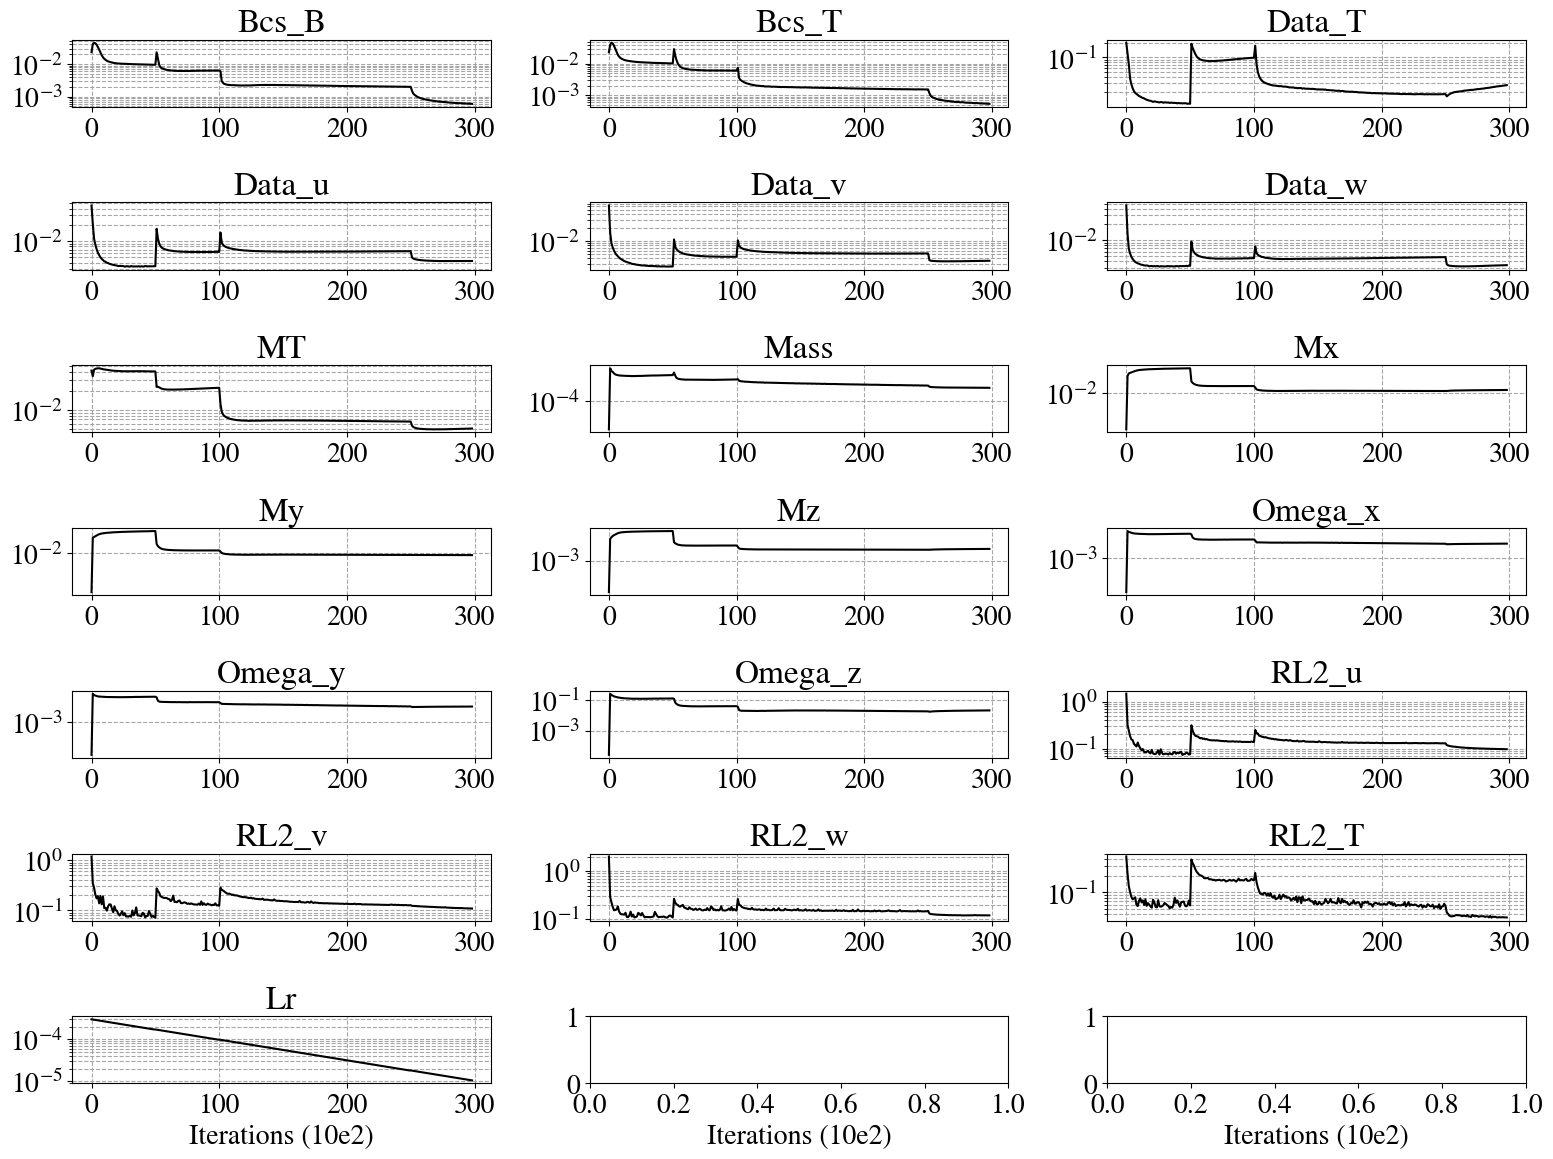

In [21]:
# Call the function
plot_losses_grid(log_loss[:-1])
plt.savefig(result_path + f'Losses.png')
print('plot')

In [22]:
def u_PINN(params):
    alpha,beta,params_NN=params
    nu_1=jnp.sqrt(Pr/Ra)
    nu_2=jnp.sqrt(1/(Pr*Ra))
    """
    input = (x, y)
    output = (u, v, p,T)
    sqrt_Pr_Ra
    sqrt_RaPr
    """
    # Neural Network
    phi_T = lambda x: (x[2])*(Y_max-x[2])/0.25#normalize it
    g_T =lambda x: - x[2]+1.0# base solution
    fn={
        "uvwT" :lambda x: pinn_fn(params_NN["uvwT"], x, M1, M2,activation_fn,norm_fn),
    }

    u, v,w,T = (
                 lambda x: u_scale*fn["uvwT"](x)[0], 
                 lambda x: v_scale*fn["uvwT"](x)[1], 
                 lambda x: w_scale*fn["uvwT"](x)[2], 
                 lambda x: g_T(x)+T_scale*phi_T(x)*fn["uvwT"](x)[3],
                 )
   # derivatives
    def derivative_fn(f, x, idx):
        """Computes df/dx[idx] using forward mode AD."""
        perturbation = jnp.zeros_like(x)
        perturbation = perturbation.at[idx].set(1.0)
        primals, tangents = jvp(f, (x,), (perturbation,))
        return tangents
    u_x = lambda x: derivative_fn(u, x, 1)
    u_y = lambda x: derivative_fn(u, x, 2)
    u_z = lambda x: derivative_fn(u, x, 3)

    v_x = lambda x: derivative_fn(v, x, 1)
    v_y = lambda x: derivative_fn(v, x, 2)
    v_z = lambda x: derivative_fn(v, x, 3)

    w_x = lambda x: derivative_fn(w, x, 1)
    w_y = lambda x: derivative_fn(w, x, 2)
    w_z = lambda x: derivative_fn(w, x, 3)
    #vorticity:
    a=lambda x: w_y(x)-v_z(x)
    b=lambda x: u_z(x)-w_x(x)
    c=lambda x: v_x(x)-u_y(x)
    Omega=lambda x: jnp.sqrt(a(x)**2+b(x)**2+c(x)**2)
    return u, v,w, Omega , T   
u_model=u_PINN

In [23]:

# %%
cmap = 'RdBu_r'
num_colors=8
# Create a colormap
cmap = plt.get_cmap(cmap)
colors = [cmap(i) for i in np.linspace(0, 1, num_colors)]
colors=colors[:num_colors//4]+colors[3*num_colors//4:]
print(len(colors))
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 20

4


plot


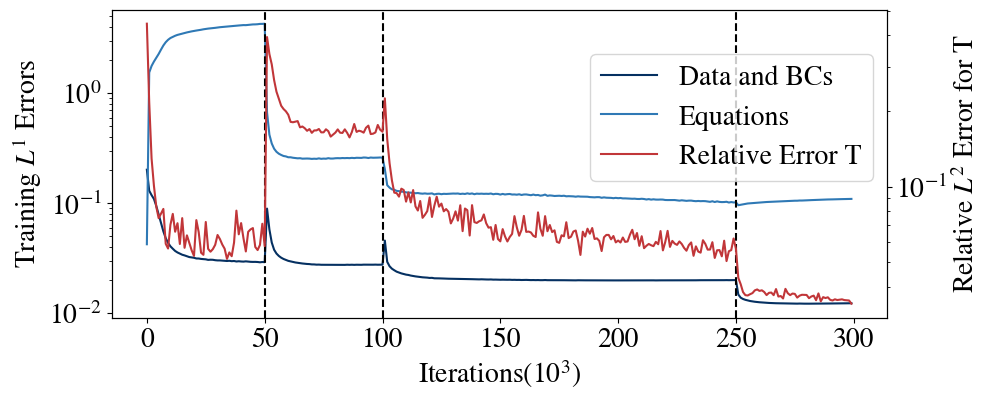

In [24]:
mpl.rcParams['font.size'] = 20
# Define the keys for the different error terms
Data_keys=['Data_u', 'Data_v','Data_w','Bcs_B','Bcs_T']
Eqn_keys=['Mx', 'My','Mz','Mass','MT','Omega_x','Omega_y','Omega_z']
Rl_error_keys=['RL2_T']

def plot_dual_axis(log_loss, Data_keys, Eqn_keys, Rl_error_keys, num_gsteps):
    iterations = np.arange(len(log_loss))  # X-axis values assuming samples are taken every 1000 iterations

    fig, ax1 = plt.subplots(figsize=(10, 4))

    # Colors for different groups
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Plot left y-axis data for the sum of Data_keys
    data_sum = np.zeros(len(log_loss))
    for key in Data_keys:
        if key in log_loss[0]:
            values = np.array([entry[key] for entry in log_loss])
            data_sum += values
    ax1.plot(iterations, data_sum, label='Data and BCs', color=colors[0])

    # Plot left y-axis data for the sum of Eqn_keys
    eqn_sum = np.zeros(len(log_loss))
    for key in Eqn_keys:
        if key in log_loss[0]:
            values = np.array([entry[key] for entry in log_loss])
            eqn_sum += values
    ax1.plot(iterations, eqn_sum, label='Equations', color=colors[1])

    ax1.set_xlabel('Iterations($10^3$)')
    ax1.set_ylabel('Training $L^1$ Errors')
    ax1.set_yscale('log')

    # Create right y-axis
    ax2 = ax1.twinx()

    # Plot right y-axis data for Rl_error_keys
    for i, key in enumerate(Rl_error_keys):
        if key in log_loss[0]:
            values = np.array([entry[key] for entry in log_loss])
            ax2.plot(iterations, values, linestyle='-',label='Relative Error T' ,color=colors[-2])
    
    ax2.set_ylabel('Relative $L^2$ Error for T')
    ax2.set_yscale('log')


    ax1.axvline(x=activate_physics/1000, color='k', linestyle='--')
    ax1.axvline(x=full_model/1000, color='k', linestyle='--')
    ax1.axvline(x=Refine_it/1000, color='k', linestyle='--')

    # Combine legends from both y-axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right', bbox_to_anchor=(1, 0.65))

    # Display the plot
    print('plot')

plot_dual_axis(log_loss, Data_keys, Eqn_keys, Rl_error_keys, num_gsteps)


In [25]:

# %%
u_fx, v_fx,w_fx, p_fx , T_fx     = u_model(params)
# Further computations for errors if any
u_pred  = vmap(u_fx, (0))(dataset['Test'][:,0:layers_1[0]])[:,None]
v_pred  = vmap(v_fx, (0))(dataset['Test'][:,0:layers_1[0]])[:,None]
w_pred  = vmap(w_fx, (0))(dataset['Test'][:,0:layers_1[0]])[:,None]
p_pred  = vmap(p_fx, (0))(dataset['Test'][:,0:layers_1[0]])[:,None]
T_pred  = vmap(T_fx, (0))(dataset['Test'][:,0:layers_1[0]])[:,None]
velocity_magnitude = np.sqrt(u_pred**2 + v_pred**2 + w_pred**2)

u_real=dataset['Test'][:,4:5]
v_real=dataset['Test'][:,5:6]
w_real=dataset['Test'][:,6:7]
T_real=dataset['Test'][:,7:8]

RL2_u = relative_error2(u_pred, dataset['Test'][:,4:5])
RL2_v = relative_error2(v_pred, dataset['Test'][:,5:6])
RL2_w = relative_error2(w_pred, dataset['Test'][:,6:7])

RL2_T = relative_error2(T_pred, dataset['Test'][:,7:8])
print(f'Relative L2 errors for u:{RL2_u:.4e},v:{RL2_v:.4e},w:{RL2_w:.4e},T:{RL2_T:.4e}')
u_max, u_min = np.max(u_pred), np.min(u_pred)
v_max, v_min = np.max(v_pred), np.min(v_pred)
w_max, w_min = np.max(w_pred), np.min(w_pred)
p_max, p_min = np.max(p_pred), np.min(p_pred)
T_max, T_min = np.max(T_pred), np.min(T_pred)
vmag_max, vmag_min= np.max(velocity_magnitude), np.min(velocity_magnitude)
Test_files={
    'txyz':dataset['Test'][:,0:layers_1[0]],
    'u':u_real,
    'v':v_real,
    'w':w_real,
    'T':T_real,
    'u_pred':u_pred,
    'v_pred':v_pred,
    'w_pred':w_pred,
    'T_pred':T_pred,
}
name_Test=result_path+'Test.mat'
scipy.io.savemat(name_Test,Test_files)
# %%
dataset['GT']=X_sol
u_fx, v_fx,w_fx, p_fx , T_fx     = u_model(params)
# Further computations for errors if any
u_pred  = vmap(u_fx, (0))(dataset['GT'][:,0:layers_1[0]])[:,None]
v_pred  = vmap(v_fx, (0))(dataset['GT'][:,0:layers_1[0]])[:,None]
w_pred  = vmap(w_fx, (0))(dataset['GT'][:,0:layers_1[0]])[:,None]
p_pred  = vmap(p_fx, (0))(dataset['GT'][:,0:layers_1[0]])[:,None]
T_pred  = vmap(T_fx, (0))(dataset['GT'][:,0:layers_1[0]])[:,None]
velocity_magnitude = np.sqrt(u_pred**2 + v_pred**2 + w_pred**2)

RL2_u = relative_error2(u_pred, dataset['GT'][:,4:5])
RL2_v = relative_error2(v_pred, dataset['GT'][:,5:6])
RL2_w = relative_error2(w_pred, dataset['GT'][:,6:7])
RL2_T = relative_error2(T_pred, dataset['GT'][:,7:8])

u_real=dataset['GT'][:,4:5]
v_real=dataset['GT'][:,5:6]
w_real=dataset['GT'][:,6:7]
T_real=dataset['GT'][:,7:8]

print(f'Relative L2 errors for u:{RL2_u:.4e},v:{RL2_v:.4e},w:{RL2_w:.4e},T:{RL2_T:.4e}')
u_max, u_min = np.max(u_real), np.min(u_real)
v_max, v_min = np.max(v_real), np.min(v_real)
w_max, w_min = np.max(w_real), np.min(w_real)
p_max, p_min = np.max(p_pred), np.min(p_pred)
T_max, T_min = np.max(T_real), np.min(T_real)
vmag_max, vmag_min= np.max(velocity_magnitude), np.min(velocity_magnitude)
GT_files={
    'txyz':dataset['GT'][:,0:layers_1[0]],
    'u':u_real,
    'v':v_real,
    'w':w_real,
    'T':T_real,
    'u_pred':u_pred,
    'v_pred':v_pred,
    'w_pred':w_pred,
    'T_pred':T_pred,
}
name_GT=result_path+'GT.mat'
scipy.io.savemat(name_GT,GT_files)

Relative L2 errors for u:9.6559e-02,v:1.0853e-01,w:1.1945e-01,T:3.4179e-02
Relative L2 errors for u:1.1028e-01,v:1.2941e-01,w:1.4583e-01,T:4.6554e-02


In [26]:
X_dataset=dataset['GT']
all_times=np.unique(X_dataset[:,0])
frame=282


idx_frame=np.argwhere(X_dataset[:,0]==all_times[frame]).flatten()
X_frame=X_dataset[idx_frame]
t_test = X_frame[:,0:1]
x_test = X_frame[:,1:2]
y_test = X_frame[:,2:3]
z_test = X_frame[:,3:4]
u_test = X_frame[:,4:5]  
v_test = X_frame[:,5:6]  
w_test = X_frame[:,6:7] 
T_test = X_frame[:,7:8] 

u_pred  = vmap(u_fx, (0))(X_frame[:,0:layers_1[0]])[:,None]
v_pred  = vmap(v_fx, (0))(X_frame[:,0:layers_1[0]])[:,None]
w_pred  = vmap(w_fx, (0))(X_frame[:,0:layers_1[0]])[:,None]
p_pred  = vmap(p_fx, (0))(X_frame[:,0:layers_1[0]])[:,None]
T_pred  = vmap(T_fx, (0))(X_frame[:,0:layers_1[0]])[:,None]

RL2_u = relative_error2(u_pred, u_test)
RL2_v = relative_error2(v_pred, v_test)
RL2_w = relative_error2(w_pred, w_test)
RL2_T = relative_error2(T_pred, T_test)

print(f'Relative L2 errors for u:{RL2_u:.4e} v:{RL2_v:.4e} w:{RL2_u:.4e} T:{RL2_T:.4e}')

V_test = np.sqrt(u_test**2 + v_test**2 + w_test**2)
V_pred = np.sqrt(u_pred**2 + v_pred**2 + w_pred**2)

Relative L2 errors for u:1.0910e-01 v:1.4814e-01 w:1.0910e-01 T:5.6797e-02


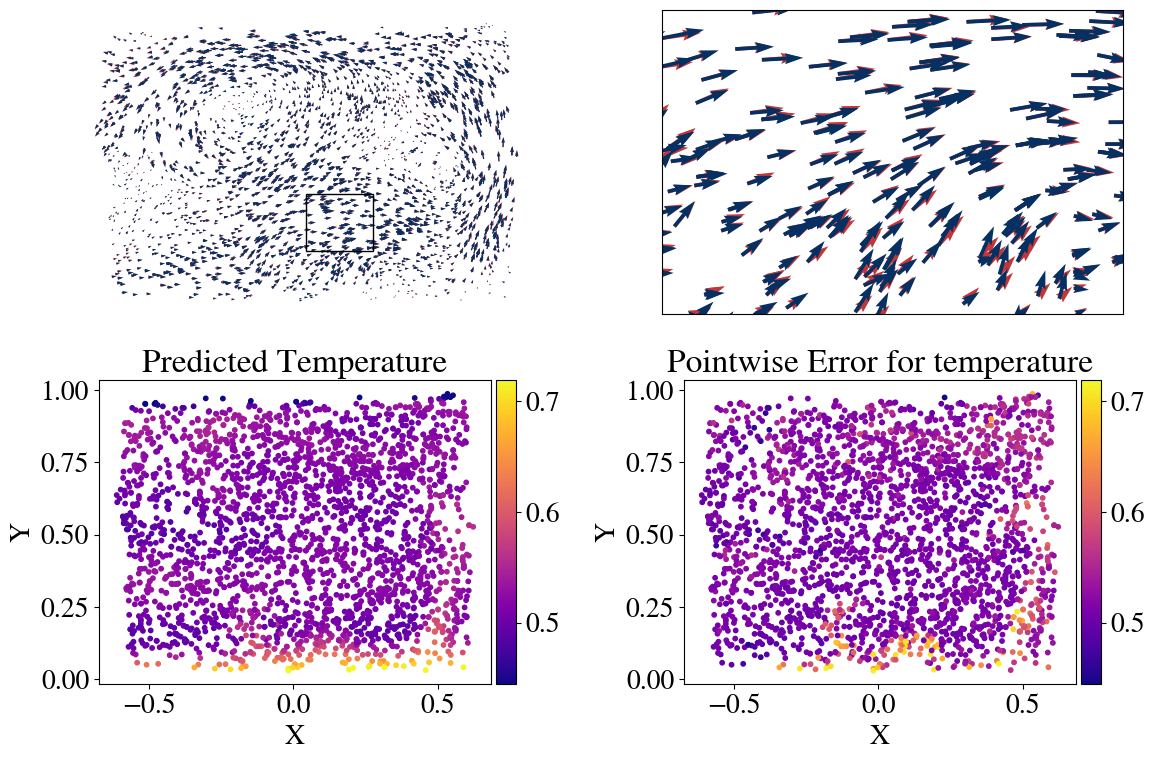

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Calculate midplane values
x_mid = np.median(x_test)
y_mid = np.median(y_test)
z_mid = np.median(z_test)

# Define tolerance for midplane filtering
tolerance = 0.05

# Create filters for midplane slices
x_filter = np.abs(x_test - x_mid) <= tolerance
y_filter = np.abs(y_test - y_mid) <= tolerance
z_filter = np.abs(z_test - z_mid) <= tolerance

# Prepare the data for plotting
data_pairs = [
    (u_test, u_pred, 'u (data)', 'u Pred'),
    (v_test, v_pred, 'v (data)', 'v Pred'),
    (w_test, w_pred, 'w (data)', 'w Pred'),
    (T_test, T_pred, 'T (data)', 'T Pred'),
    (V_test, V_pred, 'V (data)', 'V Pred')
]

# Define colormap
cmap = plt.get_cmap('plasma')

from matplotlib.patches import Rectangle

# Start plotting with adjusted figsize for just the last two rows
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Assuming you are working with the last pair in data_pairs
test_data, pred_data, test_label, pred_label = data_pairs[-1]

x, y = x_test, y_test
xlabel, ylabel = 'X', 'Y'
filter = z_filter
u, v = u_test, v_test
u_pred_sub, v_pred_sub = u_pred, v_pred


# Sampling 10% of the data for vector plotting
indices = np.random.choice(np.where(filter)[0], len(x[filter]) // 1, replace=False)
ax_test = axes[0, 0]  # First row for test data
ax_test2 = axes[0, 1]  # First row for test data
ax_pred = axes[1, 0]  # Second row for predicted data
ax_pred2 = axes[1, 1]  # Second row for predicted data

# Plot test data and vectors
ax_test.quiver(x[indices], y[indices], u_pred_sub[indices], v_pred_sub[indices], color=colors[-2],label='AIV')
ax_test.quiver(x[indices], y[indices], u[indices], v[indices], color=colors[0],alpha=1,label='Test Data')
ax_test.set_xticks([])
ax_test.set_yticks([])
ax_test.axis('off')

rectangle = Rectangle((0, 0.2), 0.2, 0.2, linewidth=1, edgecolor='black', facecolor='none')
ax_test.add_patch(rectangle)
# Plot test Subdomain
ax_test2.quiver(x[indices], y[indices], u_pred_sub[indices], v_pred_sub[indices], color=colors[-2],scale=1, width=0.008,label='AIV')
ax_test2.quiver(x[indices], y[indices], u[indices], v[indices], color=colors[0],alpha=1,scale=1, label='Test Data',width=0.008)
ax_test2.axis('equal')
ax_test2.set_xlim([0.0, 0.2])
ax_test2.set_ylim([0.1, 0.3])
ax_test2.grid(False)  # Hide the grid
ax_test2.margins(0.05)  # Set margins around the plot

# Hide tick labels on both axes
ax_test2.set_xticks([])
ax_test2.set_yticks([])

#ax_test2.legend(loc='lower left')  # Show legend if needed

# Plot predicted data and vectors
sc_pred = ax_pred.scatter(x[filter], y[filter], c=T_pred[filter], cmap=cmap, s=10,vmin=T_test[filter].min(),vmax=T_test[filter].max())
ax_pred.set_title(f'Predicted Temperature')
ax_pred.set_xlabel(xlabel)
ax_pred.set_ylabel(ylabel)
ax_pred.set_xlim([0.0, 0.2])
ax_pred.set_ylim([0.1, 0.3])
ax_pred.axis('equal')
ax_test.axis('off')

# Plot predicted data and vectors
sc_pred2 = ax_pred2.scatter(x[filter], y[filter], c=T_test[filter], cmap=cmap, s=10,vmin=T_test[filter].min(),vmax=T_test[filter].max())
ax_pred2.set_title(f'Pointwise Error for temperature')
ax_pred2.set_xlabel(xlabel)
ax_pred2.set_ylabel(ylabel)
ax_pred2.set_xlim([0.0, 0.2])
ax_pred2.set_ylim([0.1, 0.3])
ax_pred2.axis('equal')
ax_test.axis('off')


# Adding colorbars to both test and predicted plots
for ax, sc in [ (ax_pred, sc_pred),(ax_pred2, sc_pred2)]:
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(sc, cax=cax)

# Save or show the figure
plt.tight_layout()


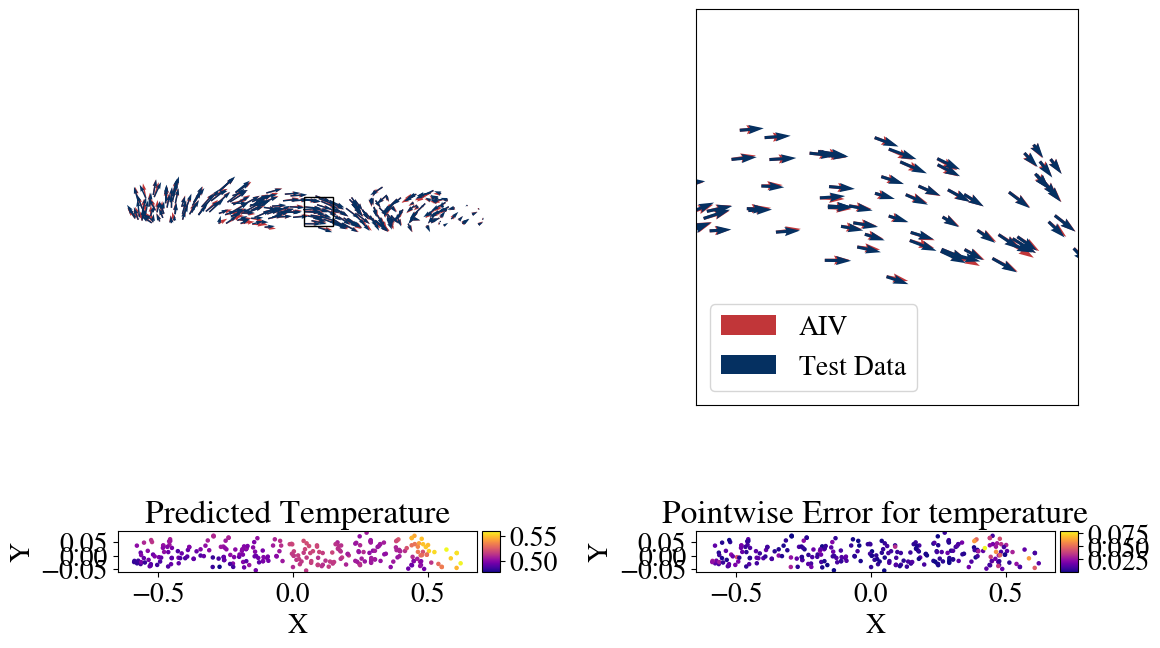

In [28]:
from matplotlib.patches import Rectangle

# Start plotting with adjusted figsize for just the last two rows
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Assuming you are working with the last pair in data_pairs
test_data, pred_data, test_label, pred_label = data_pairs[-1]

x, y = x_test, z_test
xlabel, ylabel = 'X', 'Y'
filter = y_filter
u, v = u_test, w_test
u_pred_sub, v_pred_sub = u_pred, w_pred


# Sampling 10% of the data for vector plotting
indices = np.random.choice(np.where(filter)[0], len(x[filter]) // 1, replace=False)
ax_test = axes[0, 0]  # First row for test data
ax_test2 = axes[0, 1]  # First row for test data
ax_pred = axes[1, 0]  # Second row for predicted data
ax_pred2 = axes[1, 1]  # Second row for predicted data

# Plot test data and vectors
ax_test.quiver(x[indices], y[indices], u_pred_sub[indices], v_pred_sub[indices], color=colors[-2],label='AIV')
ax_test.quiver(x[indices], y[indices], u[indices], v[indices], color=colors[0],alpha=1,label='Test Data')
# ax_test.set_xticks([])
# ax_test.set_yticks([])
# ax_test.axis('off')
ax_test.axis('equal')

rectangle = Rectangle((0, -0.05), 0.1, 0.1, linewidth=1, edgecolor='black', facecolor='none')
ax_test.add_patch(rectangle)
# Plot test Subdomain
ax_test2.quiver(x[indices], y[indices], u_pred_sub[indices], v_pred_sub[indices], color=colors[-2],scale=1, width=0.008,label='AIV')
ax_test2.quiver(x[indices], y[indices], u[indices], v[indices], color=colors[0],alpha=1,scale=1, label='Test Data',width=0.008)
ax_test2.axis('equal')
ax_test2.set_xlim([0.0, 0.1])
ax_test2.set_ylim([-0.1, 0.1])
# ax_test2.grid(False)  # Hide the grid
# ax_test2.margins(0.05)  # Set margins around the plot

# Hide tick labels on both axes
ax_test2.set_xticks([])
ax_test2.set_yticks([])

ax_test2.legend(loc='lower left')  # Show legend if needed

# Plot predicted data and vectors
sc_pred = ax_pred.scatter(x[filter], y[filter], c=T_pred[filter], cmap=cmap, s=5)
ax_pred.set_title(f'Predicted Temperature')
ax_pred.set_xlabel(xlabel)
ax_pred.set_ylabel(ylabel)
ax_pred.axis('equal')
ax_test.axis('off')

# Plot predicted data and vectors
sc_pred2 = ax_pred2.scatter(x[filter], y[filter], c=np.abs(T_pred[filter]-T_test[filter]), cmap=cmap, s=5)
ax_pred2.set_title(f'Pointwise Error for temperature')
ax_pred2.set_xlabel(xlabel)
ax_pred2.set_ylabel(ylabel)
ax_pred2.axis('equal')
ax_test.axis('off')


# Adding colorbars to both test and predicted plots
for ax, sc in [ (ax_pred, sc_pred),(ax_pred2, sc_pred2)]:
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(sc, cax=cax)

# Save or show the figure
plt.tight_layout()

In [29]:
import numpy as np

def create_cuboid_vertices(center, length_x, width_z, height_y):
    """
    Create vertices for a cuboid given the center and dimensions for length, width, and height.
    Args:
    - center (tuple): The (x, z, y) coordinates of the cuboid center.
    - length_x (float): The length of the cuboid along the x-axis.
    - width_z (float): The width of the cuboid along the z-axis.
    - height_y (float): The height of the cuboid along the y-axis.

    Returns:
    - numpy.array: An array of vertices.
    """
    x, z, y = center
    half_length_x = length_x / 2
    half_width_z = width_z / 2
    half_height_y = height_y / 2

    # Define the vertices of the cuboid
    vertices = np.array([
        [x - half_length_x, z - half_width_z, y - half_height_y],  # Bottom face, corner 1
        [x + half_length_x, z - half_width_z, y - half_height_y],  # Bottom face, corner 2
        [x + half_length_x, z + half_width_z, y - half_height_y],  # Bottom face, corner 3
        [x - half_length_x, z + half_width_z, y - half_height_y],  # Bottom face, corner 4
        [x - half_length_x, z - half_width_z, y + half_height_y],  # Top face, corner 1
        [x + half_length_x, z - half_width_z, y + half_height_y],  # Top face, corner 2
        [x + half_length_x, z + half_width_z, y + half_height_y],  # Top face, corner 3
        [x - half_length_x, z + half_width_z, y + half_height_y]   # Top face, corner 4
    ])
    return vertices

# Example usage:
center = (0.3, 0.3, 0.0)  # Center in (x, z, y) format
length_x = 0.2  # Length along the x-axis
width_z = 0.1  # Width along the z-axis
height_y = 0.4  # Height along the y-axis

vertices = create_cuboid_vertices(center, length_x, width_z, height_y)
print(vertices)


[[ 0.2   0.25 -0.2 ]
 [ 0.4   0.25 -0.2 ]
 [ 0.4   0.35 -0.2 ]
 [ 0.2   0.35 -0.2 ]
 [ 0.2   0.25  0.2 ]
 [ 0.4   0.25  0.2 ]
 [ 0.4   0.35  0.2 ]
 [ 0.2   0.35  0.2 ]]


In [30]:
dataset.keys()

dict_keys(['Data', 'Data_T', 'Bcs_T', 'Bcs_B', 'Test', 'Res', 'GT'])

In [31]:

# %%
u_fx, v_fx,w_fx, p_fx , T_fx     = u_model(params)
# Further computations for errors if any
u_pred  = vmap(u_fx, (0))(dataset['Data_T'][:,0:layers_1[0]])[:,None]
v_pred  = vmap(v_fx, (0))(dataset['Data_T'][:,0:layers_1[0]])[:,None]
w_pred  = vmap(w_fx, (0))(dataset['Data_T'][:,0:layers_1[0]])[:,None]
p_pred  = vmap(p_fx, (0))(dataset['Data_T'][:,0:layers_1[0]])[:,None]
T_pred  = vmap(T_fx, (0))(dataset['Data_T'][:,0:layers_1[0]])[:,None]
velocity_magnitude = np.sqrt(u_pred**2 + v_pred**2 + w_pred**2)

u_real=dataset['Data_T'][:,4:5]
v_real=dataset['Data_T'][:,5:6]
w_real=dataset['Data_T'][:,6:7]
T_real=dataset['Data_T'][:,7:8]

RL2_u = relative_error2(u_pred, dataset['Data_T'][:,4:5])
RL2_v = relative_error2(v_pred, dataset['Data_T'][:,5:6])
RL2_w = relative_error2(w_pred, dataset['Data_T'][:,6:7])
RL2_T = relative_error2(T_pred, dataset['Data_T'][:,7:8])
print(f'Relative L2 errors for u:{RL2_u:.4e},v:{RL2_v:.4e},w:{RL2_w:.4e},T:{RL2_T:.4e}')
u_max, u_min = np.max(u_pred), np.min(u_pred)
v_max, v_min = np.max(v_pred), np.min(v_pred)
w_max, w_min = np.max(w_pred), np.min(w_pred)
p_max, p_min = np.max(p_pred), np.min(p_pred)
T_max, T_min = np.max(T_pred), np.min(T_pred)
vmag_max, vmag_min= np.max(velocity_magnitude), np.min(velocity_magnitude)

Relative L2 errors for u:9.7083e-02,v:1.0911e-01,w:1.1971e-01,T:3.4371e-02


plot


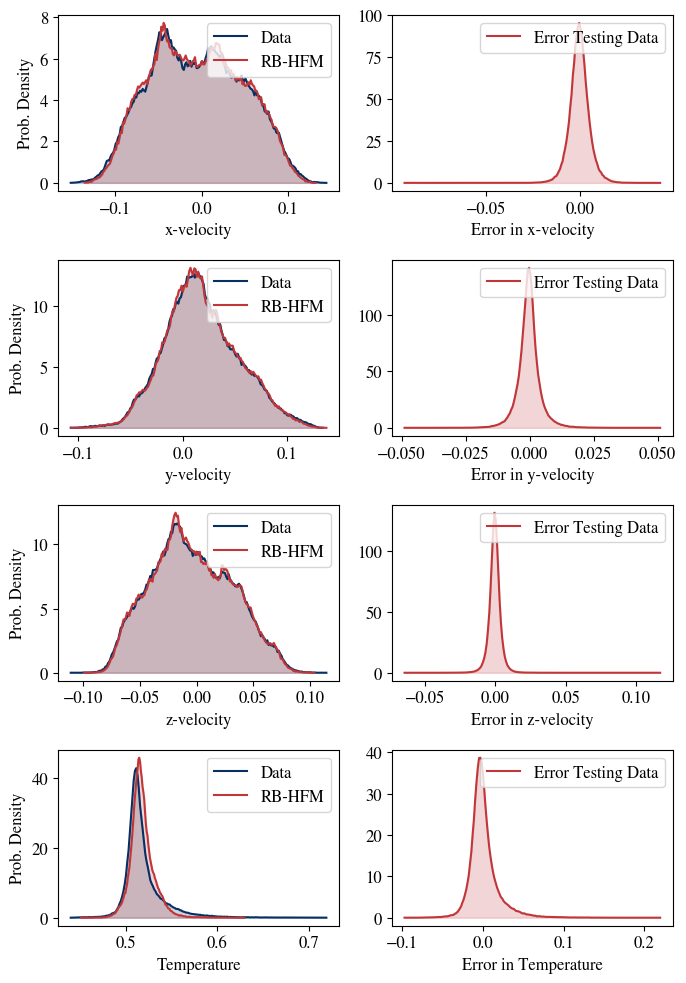

In [32]:

# %%


def get_pdf(u_hist, bins=30):
    hist, bins = np.histogram(u_hist, bins=bins, density=True)
    prob_density = hist
    return prob_density, bins
def get_colors_plot(cmap='RdBu', n_colors=2):
    cmap = plt.get_cmap(cmap)
    colors = [cmap(i) for i in np.linspace(0, 1, n_colors)]
    return colors
def plot_pdf_fields_with_error(datasets, field_names, colors, bins=200, figsize=(7, 10)):
    num_fields = len(datasets)
    fig, axs = plt.subplots(num_fields, 2, figsize=figsize)  # 3 columns for data, RBA, and error

    for i, ((data_piv, data_aiv), field_name) in enumerate(zip(datasets, field_names)):
        prob_density_piv, bins_piv = get_pdf(data_piv, bins=bins)
        prob_density_aiv, bins_aiv = get_pdf(data_aiv, bins=bins)
        error = data_piv - data_aiv
        prob_density_error, bins_error = get_pdf(error, bins=bins)

        # Plotting data
        axs[i, 0].plot(bins_piv[:-1], prob_density_piv, color=colors[0], label=f'Data')
        axs[i, 0].fill_between(bins_piv[:-1], prob_density_piv, color=colors[0], alpha=0.2)
        axs[i, 0].set_xlabel(f'{field_name}')
        axs[i, 0].plot(bins_aiv[:-1], prob_density_aiv, color=colors[-2], label='RB-HFM')
        axs[i, 0].fill_between(bins_aiv[:-1], prob_density_aiv, color=colors[-2], alpha=0.2)
        axs[i, 0].set_xlabel(f'{field_name}')
        axs[i, 0].set_ylabel('Prob. Density')
        axs[i, 0].legend(loc='upper right')

        # Plotting error
        axs[i, 1].plot(bins_error[:-1], prob_density_error, color=colors[-2], label='Error Testing Data')
        axs[i, 1].fill_between(bins_error[:-1], prob_density_error, color=colors[-2], alpha=0.2)
        axs[i, 1].set_xlabel(f'Error in {field_name}')
        axs[i, 1].legend(loc='upper right')

    plt.tight_layout()
    return fig


# Extracting and reshaping data
u_piv_hist = np.array(jax.device_get(dataset['Data_T'][:,4:5])).reshape(-1)
u_aiv_hist = np.array(jax.device_get(u_pred)).reshape(-1)
v_piv_hist = np.array(jax.device_get(dataset['Data_T'][:,5:6])).reshape(-1)
v_aiv_hist = np.array(jax.device_get(v_pred)).reshape(-1)
w_piv_hist = np.array(jax.device_get(dataset['Data_T'][:,6:7])).reshape(-1)
w_aiv_hist = np.array(jax.device_get(w_pred)).reshape(-1)  # Assuming w_pred is defined
T_piv_hist = np.array(jax.device_get(dataset['Data_T'][:,7:8])).reshape(-1)
T_aiv_hist = np.array(jax.device_get(T_pred)).reshape(-1)  # Assuming T_pred is defined

bins = 40

# Calculating probability densities
prob_density_u_piv, bins_u_piv = get_pdf(u_piv_hist, bins=bins)
prob_density_u_aiv, bins_u_aiv = get_pdf(u_aiv_hist, bins=bins)
prob_density_v_piv, bins_v_piv = get_pdf(v_piv_hist, bins=bins)
prob_density_v_aiv, bins_v_aiv = get_pdf(v_aiv_hist, bins=bins)
prob_density_w_piv, bins_w_piv = get_pdf(w_piv_hist, bins=bins)
prob_density_w_aiv, bins_w_aiv = get_pdf(w_aiv_hist, bins=bins)
prob_density_T_piv, bins_T_piv = get_pdf(T_piv_hist, bins=bins)
prob_density_T_aiv, bins_T_aiv = get_pdf(T_aiv_hist, bins=bins)



colors = get_colors_plot(cmap='RdBu_r', n_colors=8)
datasets = [(u_piv_hist, u_aiv_hist), (v_piv_hist, v_aiv_hist), 
            (w_piv_hist, w_aiv_hist), (T_piv_hist, T_aiv_hist)]
field_names = ['x-velocity', 'y-velocity', 'z-velocity', 'Temperature']
mpl.rcParams['font.size'] = 12

fig = plot_pdf_fields_with_error(datasets, field_names, colors)

plt.savefig(result_path + '/AIV-Prob_dist_epochs.png')
print('plot')


plot


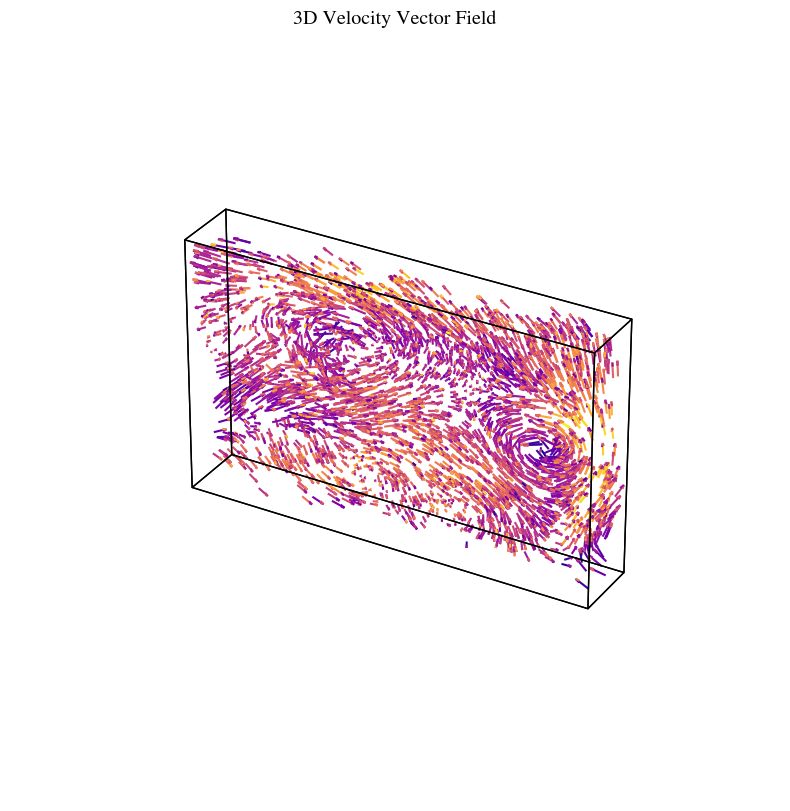

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Create a 3D figure
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Extracting data for plotting
t_test = X_frame[:, 0:1].flatten()
x_test = X_frame[:, 1:2].flatten()
y_test = X_frame[:, 2:3].flatten()
z_test = X_frame[:, 3:4].flatten()
u_test = X_frame[:, 4:5].flatten()
v_test = X_frame[:, 5:6].flatten()
w_test = X_frame[:, 6:7].flatten()
T_test = X_frame[:, 7:8].flatten()

# Predicted values
u_pred = vmap(u_fx, (0))(X_frame[:, 0:layers_1[0]]).flatten()
v_pred = vmap(v_fx, (0))(X_frame[:, 0:layers_1[0]]).flatten()
w_pred = vmap(w_fx, (0))(X_frame[:, 0:layers_1[0]]).flatten()
T_pred = vmap(T_fx, (0))(X_frame[:, 0:layers_1[0]]).flatten()

V_test = np.sqrt(u_test**2 + v_test**2 + w_test**2)

# Normalize the colors
norm = plt.Normalize(V_test.min(), V_test.max())
colors2 = cm.plasma(norm(V_test))

# Plotting the vectors



quiver = ax.quiver(x_test, z_test, y_test, u_pred, w_pred, v_pred, color=colors2, length=0.05, normalize=True)

center = (0.0, 0.0, 0.5)  # (x, z, y) center of the cuboid
side_length = 0.2  # Length of each side of the cuboid
length_x = 1.2  # Length along the x-axis
width_z = 0.2  # Width along the z-axis
height_y = 1.0  # Height along the y-axis
vertices = create_cuboid_vertices(center, length_x, width_z, height_y)
# Create the sides (faces) of the rectangle (cuboid)
faces = [[vertices[i] for i in [0, 1, 5, 4]], [vertices[i] for i in [1, 2, 6, 5]],
         [vertices[i] for i in [2, 3, 7, 6]], [vertices[i] for i in [3, 0, 4, 7]],
         [vertices[i] for i in [4, 5, 6, 7]], [vertices[i] for i in [0, 3, 2, 1]]]

# Setting labels
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')

# Set title
ax.set_title('3D Velocity Vector Field')

# Set the aspect of the plot to be equal
mid_x = (x_test.max() + x_test.min()) / 2
mid_y = (y_test.max() + y_test.min()) / 2
mid_z = (z_test.max() + z_test.min()) / 2
max_range = np.array([x_test.max()-x_test.min(), y_test.max()-y_test.min(), z_test.max()-z_test.min()]).max() / 2.0
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_zlim(mid_y - max_range, mid_y + max_range)
ax.set_ylim(mid_z - max_range, mid_z + max_range)
rectangle = Poly3DCollection(faces, facecolors='green', linewidths=1, edgecolors='k', alpha=0.0)
ax.add_collection3d(rectangle)
center = (0.0, 0.0, 0.3)  # (x, z, y) center of the cuboid
side_length = 0.2  # Length of each side of the cuboid
length_x = 0.2  # Length along the x-axis
width_z = 0.2  # Width along the z-axis
height_y = 0.2  # Height along the y-axis
vertices = create_cuboid_vertices(center, length_x, width_z, height_y)
# Create the sides (faces) of the rectangle (cuboid)
faces = [[vertices[i] for i in [0, 1, 5, 4]], [vertices[i] for i in [1, 2, 6, 5]],
         [vertices[i] for i in [2, 3, 7, 6]], [vertices[i] for i in [3, 0, 4, 7]],
         [vertices[i] for i in [4, 5, 6, 7]], [vertices[i] for i in [0, 3, 2, 1]]]

rectangle = Poly3DCollection(faces, facecolors='green', linewidths=1, edgecolors='k', alpha=0.0)
#ax.add_collection3d(rectangle)
ax.set_axis_off()

print('plot')


plot


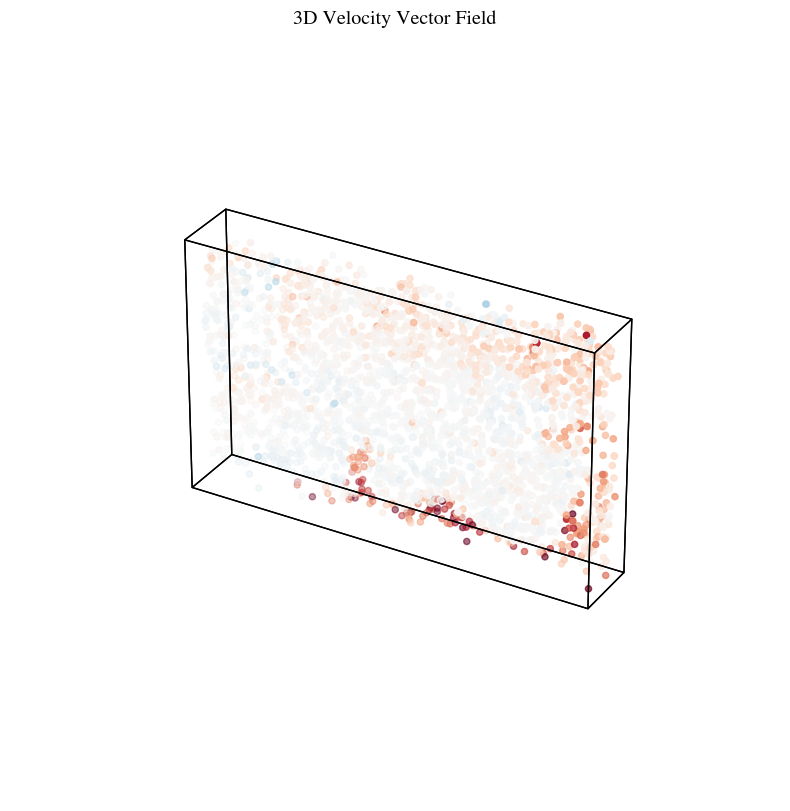

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Create a 3D figure
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Extracting data for plotting
t_test = X_frame[:, 0:1].flatten()
x_test = X_frame[:, 1:2].flatten()
y_test = X_frame[:, 2:3].flatten()
z_test = X_frame[:, 3:4].flatten()
u_test = X_frame[:, 4:5].flatten()
v_test = X_frame[:, 5:6].flatten()
w_test = X_frame[:, 6:7].flatten()
T_test = X_frame[:, 7:8].flatten()

# Predicted values
u_pred = vmap(u_fx, (0))(X_frame[:, 0:layers_1[0]]).flatten()
v_pred = vmap(v_fx, (0))(X_frame[:, 0:layers_1[0]]).flatten()
w_pred = vmap(w_fx, (0))(X_frame[:, 0:layers_1[0]]).flatten()
T_pred = vmap(T_fx, (0))(X_frame[:, 0:layers_1[0]]).flatten()

V_test = np.sqrt(u_test**2 + v_test**2 + w_test**2)

# Normalize the colors
norm = plt.Normalize(V_test.min(), V_test.max())
colors2 = cm.plasma(norm(V_test))

# Plotting the vectors



scatter = ax.scatter(x_test, z_test, y_test, c=T_test, cmap='RdBu_r',s=20,vmin=0.31,vmax= 0.71)

center = (0.0, 0.0, 0.5)  # (x, z, y) center of the cuboid
side_length = 0.2  # Length of each side of the cuboid
length_x = 1.2  # Length along the x-axis
width_z = 0.2  # Width along the z-axis
height_y = 1.0  # Height along the y-axis
vertices = create_cuboid_vertices(center, length_x, width_z, height_y)
# Create the sides (faces) of the rectangle (cuboid)
faces = [[vertices[i] for i in [0, 1, 5, 4]], [vertices[i] for i in [1, 2, 6, 5]],
         [vertices[i] for i in [2, 3, 7, 6]], [vertices[i] for i in [3, 0, 4, 7]],
         [vertices[i] for i in [4, 5, 6, 7]], [vertices[i] for i in [0, 3, 2, 1]]]

# Setting labels
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')

# Set title
ax.set_title('3D Velocity Vector Field')

# Set the aspect of the plot to be equal
mid_x = (x_test.max() + x_test.min()) / 2
mid_y = (y_test.max() + y_test.min()) / 2
mid_z = (z_test.max() + z_test.min()) / 2
max_range = np.array([x_test.max()-x_test.min(), y_test.max()-y_test.min(), z_test.max()-z_test.min()]).max() / 2.0
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_zlim(mid_y - max_range, mid_y + max_range)
ax.set_ylim(mid_z - max_range, mid_z + max_range)
rectangle = Poly3DCollection(faces, facecolors='green', linewidths=1, edgecolors='k', alpha=0.0)
ax.add_collection3d(rectangle)
center = (0.0, 0.0, 0.3)  # (x, z, y) center of the cuboid
side_length = 0.2  # Length of each side of the cuboid
length_x = 0.2  # Length along the x-axis
width_z = 0.2  # Width along the z-axis
height_y = 0.2  # Height along the y-axis
vertices = create_cuboid_vertices(center, length_x, width_z, height_y)
# Create the sides (faces) of the rectangle (cuboid)
faces = [[vertices[i] for i in [0, 1, 5, 4]], [vertices[i] for i in [1, 2, 6, 5]],
         [vertices[i] for i in [2, 3, 7, 6]], [vertices[i] for i in [3, 0, 4, 7]],
         [vertices[i] for i in [4, 5, 6, 7]], [vertices[i] for i in [0, 3, 2, 1]]]

rectangle = Poly3DCollection(faces, facecolors='green', linewidths=1, edgecolors='k', alpha=0.0)
#ax.add_collection3d(rectangle)
ax.set_axis_off()

print('plot')


100%|██████████| 1/1 [00:08<00:00,  8.28s/it]

plot


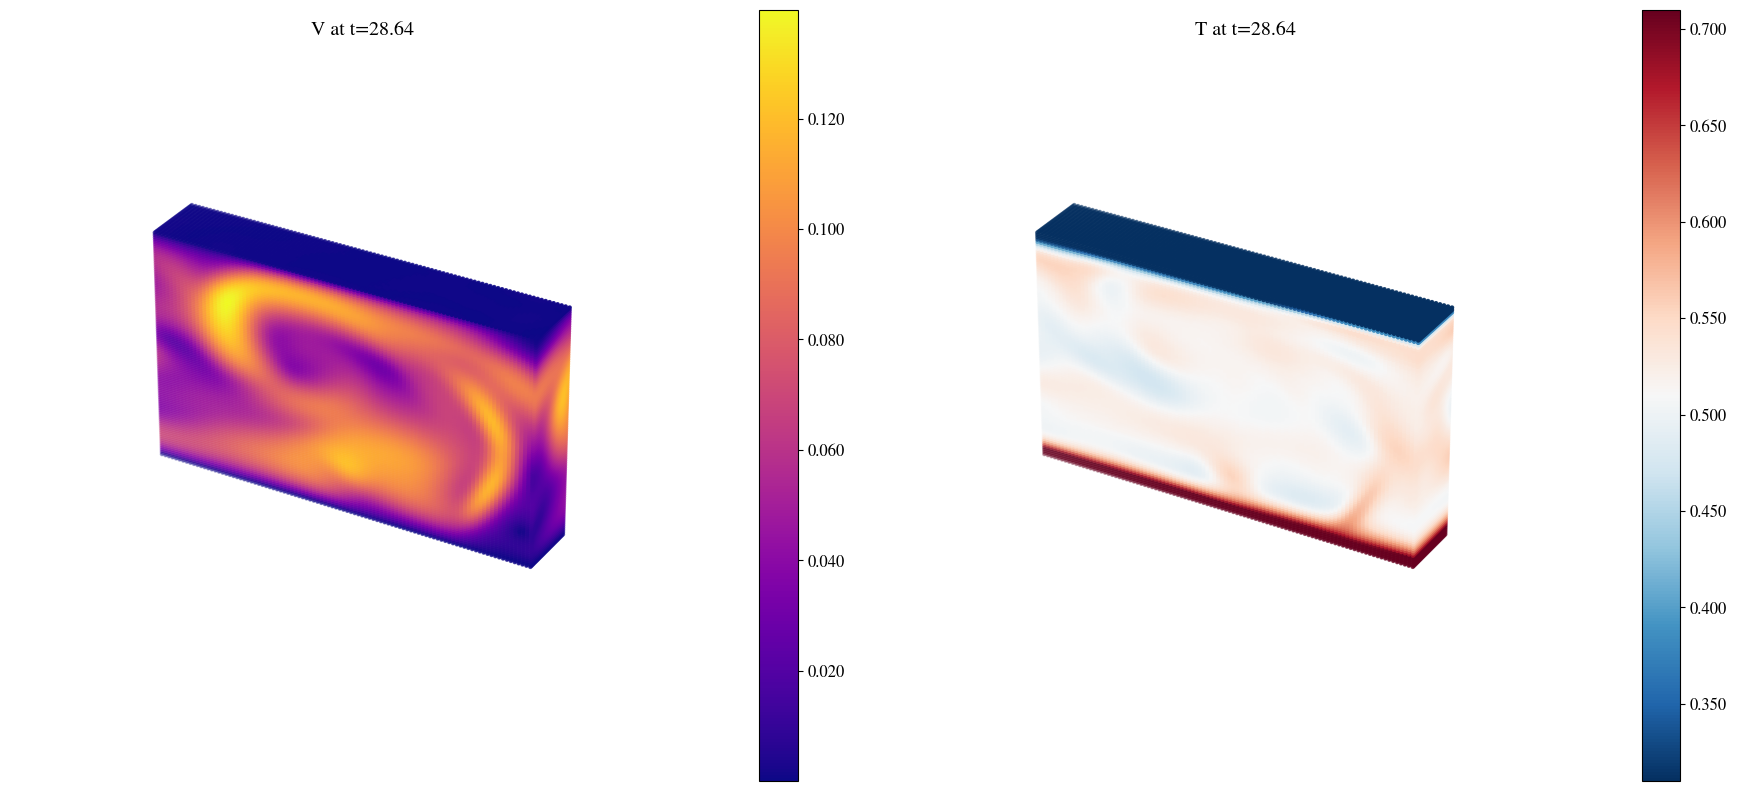

In [35]:
# Calculate the magnitude of the velocity vector
# Define tolerance for proximity to midpoints
tolerance = 0.01
all_times=np.sort(np.unique(dataset['GT'][:,0]))
# Find midpoints in spatial dimensions
mid_x = np.max(X_eval[:, 0])
mid_y = np.max(X_eval[:, 1])
mid_z = np.min(X_eval[:, 2])

# Find indices near midpoints in spatial dimensions
near_mid_x = np.where(np.abs(X_eval[:, 0] - mid_x) < tolerance)[0]
near_mid_y = np.where(np.abs(X_eval[:, 1] - mid_y) < tolerance)[0]
near_mid_z = np.where(np.abs(X_eval[:, 2] - mid_z) < tolerance)[0]

# Get the intersection of indices
common_indices = np.union1d(near_mid_x, np.union1d(near_mid_y, near_mid_z))

# Extract the relevant points
X_midpoints_not = X_eval[common_indices]

start=264
end=start+1
#end=len(all_times)


for start in tqdm.tqdm(range(start,end)):
    target_time=all_times[start]
    X_midpoints = np.hstack((X_midpoints_not[:, 0:1] *0+ target_time, X_midpoints_not))

    # Get model predictions
    u_pred, v_pred, w_pred, p_pred, T_pred = u_model(params)
    u_pred_mid = vmap(u_pred, (0))(X_midpoints)[:, None]
    v_pred_mid = vmap(v_pred, (0))(X_midpoints)[:, None]
    w_pred_mid = vmap(w_pred, (0))(X_midpoints)[:, None]
    p_pred_mid = vmap(p_pred, (0))(X_midpoints)[:, None]
    T_pred_mid = vmap(T_pred, (0))(X_midpoints)[:, None]
    e_T_pred_mid = vmap(T_pred, (0))(X_midpoints)[:, None]

    velocity_magnitude = np.sqrt(u_pred_mid**2 + v_pred_mid**2 + w_pred_mid**2)

    # Create a 3x2 subplot grid
    fig = plt.figure(figsize=(18, 10))

    variables = [velocity_magnitude, T_pred_mid]
    titles = ['V','T']
    # Calculate the max range for true dimensions
    max_range = np.array([X_midpoints[:, 1].max() - X_midpoints[:, 1].min(), 
                        X_midpoints[:, 2].max() - X_midpoints[:, 2].min(), 
                        X_midpoints[:, 3].max() - X_midpoints[:, 3].min()]).max() / 2.0

    mid_x = X_midpoints[:, 1].mean()
    mid_z = X_midpoints[:, 3].mean()
    mid_y = X_midpoints[:, 2].mean()
    T_min=0.4
    T_max=0.7

    min_max_values = [(velocity_magnitude.min(), velocity_magnitude.max()),(0.31, 0.71),(0.41, 0.61 )]

    for i, (variable, title, (vmin, vmax)) in enumerate(zip(variables, titles, min_max_values)):
        ax = fig.add_subplot(1, 2, i + 1, projection='3d')
        if title=='V':
            scatter = ax.scatter(X_midpoints[:, 1], X_midpoints[:, 3], X_midpoints[:, 2], c=variable.ravel(), cmap='plasma',vmin=vmin, vmax=vmax, s=5)
        else:
            scatter = ax.scatter(X_midpoints[:, 1], X_midpoints[:, 3], X_midpoints[:, 2], c=variable.ravel(), cmap='RdBu_r', vmin=vmin, vmax=vmax, s=5)
           
        ax.set_title(f'{title} at t={target_time:.2f}')

        cbar = plt.colorbar(scatter, ax=ax, shrink=0.8, aspect=20)
        cbar.formatter = FormatStrFormatter('%.3f')
        cbar.update_ticks()

        # Set the same limits for all three axes based on the max range
        ax.set_xlim(mid_x - max_range, mid_x + max_range)
        ax.set_ylim(mid_z - max_range, mid_z + max_range)
        ax.set_zlim(mid_y - max_range, mid_y + max_range)

        plt.axis('off')

    plt.tight_layout()
    plt.savefig(All_path + f"at_t={(target_time/len(all_times)):.5f}.png")
    if start + 1 < end:
        plt.close()
    else:
        print('plot')


(817686, 3, 3)


100%|██████████| 817686/817686 [00:29<00:00, 27767.08it/s]


plot


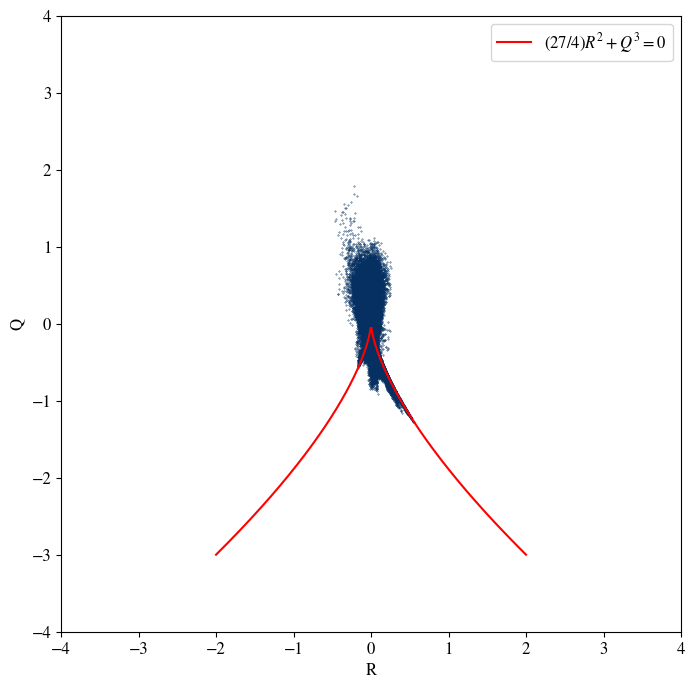

In [36]:
def QR(params,Ra):
    alpha,beta,params_NN=params
    nu_1=jnp.sqrt(Pr/Ra)
    nu_2=jnp.sqrt(1/(Pr*Ra))
    # Neural Network
    phi_T = lambda x: (x[2])*(Y_max-x[2])/0.25#normalize it
    g_T =lambda x: - x[2]+1.0# base solution
    fn={
        "uvwT" :lambda x: pinn_fn(params_NN["uvwT"], x, M1, M2,activation_fn,norm_fn),
    }

    u, v,w,T = (
                 lambda x: u_scale*fn["uvwT"](x)[0], 
                 lambda x: v_scale*fn["uvwT"](x)[1], 
                 lambda x: w_scale*fn["uvwT"](x)[2], 
                 lambda x: g_T(x)+T_scale*phi_T(x)*fn["uvwT"](x)[3],
                 )
   # derivatives
    def derivative_fn(f, x, idx):
        """Computes df/dx[idx] using forward mode AD."""
        perturbation = jnp.zeros_like(x)
        perturbation = perturbation.at[idx].set(1.0)
        primals, tangents = jvp(f, (x,), (perturbation,))
        return tangents

    u_t = lambda x: derivative_fn(u, x, 0)
    u_x = lambda x: derivative_fn(u, x, 1)
    u_y = lambda x: derivative_fn(u, x, 2)
    u_z = lambda x: derivative_fn(u, x, 3)

    v_t = lambda x: derivative_fn(v, x, 0)
    v_x = lambda x: derivative_fn(v, x, 1)
    v_y = lambda x: derivative_fn(v, x, 2)
    v_z = lambda x: derivative_fn(v, x, 3)

    w_t = lambda x: derivative_fn(w, x, 0)
    w_x = lambda x: derivative_fn(w, x, 1)
    w_y = lambda x: derivative_fn(w, x, 2)
    w_z = lambda x: derivative_fn(w, x, 3)
    # equations
    A11 = lambda x: u_x(x)
    A12 = lambda x: u_y(x)
    A13 = lambda x: u_z(x)
    A21 = lambda x: v_x(x)
    A22 = lambda x: v_y(x)
    A23 = lambda x: v_z(x)
    A31 = lambda x: w_x(x)
    A32 = lambda x: w_y(x)
    A33 = lambda x: w_z(x)


    return A11,A12,A13,A21,A22,A23,A31,A32,A33
A11_fx,A12_fx,A13_fx,A21_fx,A22_fx,A23_fx,A31_fx,A32_fx,A33_fx  = QR(params,Ra)
# Further computations for errors if any
A11  = vmap(A11_fx, (0))(dataset['Res'][:,0:layers_1[0]])[:,None]
A12  = vmap(A12_fx, (0))(dataset['Res'][:,0:layers_1[0]])[:,None]
A13  = vmap(A13_fx, (0))(dataset['Res'][:,0:layers_1[0]])[:,None]

A21  = vmap(A21_fx, (0))(dataset['Res'][:,0:layers_1[0]])[:,None]
A22  = vmap(A22_fx, (0))(dataset['Res'][:,0:layers_1[0]])[:,None]
A23  = vmap(A23_fx, (0))(dataset['Res'][:,0:layers_1[0]])[:,None]

A31  = vmap(A31_fx, (0))(dataset['Res'][:,0:layers_1[0]])[:,None]
A32  = vmap(A32_fx, (0))(dataset['Res'][:,0:layers_1[0]])[:,None]
A33  = vmap(A33_fx, (0))(dataset['Res'][:,0:layers_1[0]])[:,None]
depth=len(A11)
Aij=np.zeros((depth,3,3))
print(Aij.shape)
#Filling the matrix
Aij[:,0,0]=A11.flatten()
Aij[:,0,1]=A12.flatten()
Aij[:,0,2]=A13.flatten()
Aij[:,1,0]=A21.flatten()
Aij[:,1,1]=A22.flatten()
Aij[:,1,2]=A23.flatten()
Aij[:,2,0]=A31.flatten()
Aij[:,2,1]=A32.flatten()
Aij[:,2,2]=A33.flatten()
Q=[]

for k in tqdm.tqdm(range(len(Aij))):
    Q.append((-1/2)*np.sum(Aij[k]*Aij[k].T))
R=[]
for k in tqdm.tqdm(range(len(Aij))):
    A=Aij[k]
    R_point=0
    for i in range(3):
        for m in range(3):
            for n in range(3):
               R_point=R_point+A[i][m]*A[m][n]*A[n][i]
    R.append((-1/3)*R_point)
plt.figure(figsize=(8, 8))

plt.scatter(R,Q,s=0.1)
plt.xlim(-4, 4)
plt.ylim(-4, 4)

# Generate R values
R_values = np.linspace(-2, 2, 400)
# Calculate Q values from the curve equation
Q_values = -((27/4) * R_values**2)**(1/3)

# Plot the curve
plt.plot(R_values, Q_values, label='$(27/4)R^2 + Q^3 = 0$', color='red')

# Add labels to the axes
plt.xlabel('R')
plt.ylabel('Q')

# Add legend
plt.legend(loc='upper right')

plt.savefig(result_path + '/QR_plot.png')
print('plot')





In [37]:

# %%
Aji = np.transpose(Aij, (0, 2, 1))
e_k=(1/2)*(np.sqrt(Pr/Ra))*(Aij+Aji)
e_k_all=[]
# %%
# Calculate the magnitude of the velocity vector
# Define tolerance for proximity to midpoints
tolerance = 0.01
all_times=np.sort(np.unique(X_train[:,0]))
# Find midpoints in spatial dimensions
mid_x = np.max(X_eval[:, 0])
mid_y = np.max(X_eval[:, 1])
mid_z = np.min(X_eval[:, 2])

# Find indices near midpoints in spatial dimensions
near_mid_x = np.where(np.abs(X_eval[:, 0] - mid_x) < tolerance)[0]
near_mid_y = np.where(np.abs(X_eval[:, 1] - mid_y) < tolerance)[0]
near_mid_z = np.where(np.abs(X_eval[:, 2] - mid_z) < tolerance)[0]

# Get the intersection of indices
common_indices = np.union1d(near_mid_x, np.union1d(near_mid_y, near_mid_z))



In [38]:

# Extract the relevant points
X_midpoints_not = X_eval[common_indices]

start=0
end=start+1
#end=len(all_times)


for start in tqdm.tqdm(range(start,end)):
    target_time=all_times[start]
    X_midpoints = np.hstack((X_midpoints_not[:, 0:1] *0+ target_time, X_midpoints_not))

    # Get model predictions
    u_pred, v_pred, w_pred, p_pred, T_pred = u_model(params)
    e_T_pred   = epislon_T(params,Ra)
    u_pred_mid = vmap(u_pred, (0))(X_midpoints)[:, None]
    v_pred_mid = vmap(v_pred, (0))(X_midpoints)[:, None]
    w_pred_mid = vmap(w_pred, (0))(X_midpoints)[:, None]
    p_pred_mid = vmap(p_pred, (0))(X_midpoints)[:, None]
    T_pred_mid = vmap(T_pred, (0))(X_midpoints)[:, None]
    e_T_pred_mid = vmap(T_pred, (0))(X_midpoints)[:, None]

    velocity_magnitude = np.sqrt(u_pred_mid**2 + v_pred_mid**2 + w_pred_mid**2)

    # Create a 3x2 subplot grid
    fig = plt.figure(figsize=(18, 10))

    variables = [u_pred_mid, v_pred_mid, w_pred_mid, velocity_magnitude, p_pred_mid, T_pred_mid,e_T_pred_mid]
    titles = ['u', 'v', 'w', 'V', 'Omega', 'T','e_T']
    # Calculate the max range for true dimensions
    max_range = np.array([X_midpoints[:, 1].max() - X_midpoints[:, 1].min(), 
                        X_midpoints[:, 2].max() - X_midpoints[:, 2].min(), 
                        X_midpoints[:, 3].max() - X_midpoints[:, 3].min()]).max() / 2.0

    mid_x = X_midpoints[:, 1].mean()
    mid_z = X_midpoints[:, 3].mean()
    mid_y = X_midpoints[:, 2].mean()
    min_max_values = [(u_min, u_max), (v_min, v_max), (w_min, w_max), (vmag_min, vmag_max), (p_min, p_max), (T_min, T_max),(e_T_min, e_T_max )]

    for i, (variable, title, (vmin, vmax)) in enumerate(zip(variables, titles, min_max_values)):
        ax = fig.add_subplot(3, 3, i + 1, projection='3d')
        if title=='e_T':
            scatter = ax.scatter(X_midpoints[:, 1], X_midpoints[:, 3], X_midpoints[:, 2], c=variable.ravel(), cmap='RdBu_r',s=5)# vmin=vmin, vmax=vmax, s=5)
        else:
            scatter = ax.scatter(X_midpoints[:, 1], X_midpoints[:, 3], X_midpoints[:, 2], c=variable.ravel(), cmap='RdBu_r', vmin=vmin, vmax=vmax, s=5)
           
        ax.set_title(f'{title} at t={target_time:.2f}')

        cbar = plt.colorbar(scatter, ax=ax, shrink=0.8, aspect=20)
        cbar.formatter = FormatStrFormatter('%.3f')
        cbar.update_ticks()

        # Set the same limits for all three axes based on the max range
        ax.set_xlim(mid_x - max_range, mid_x + max_range)
        ax.set_ylim(mid_z - max_range, mid_z + max_range)
        ax.set_zlim(mid_y - max_range, mid_y + max_range)

        plt.axis('off')

    plt.tight_layout()
    plt.savefig(All_path + f"at_t={(target_time/len(all_times)):.5f}.png")
    if start + 1 < end:
        plt.close()
    else:
        print('plot')
image_folder= All_path
video_name=dataset_name+'3D.mp4'
make_video(image_folder, video_name, 20) # 10 is the FPS (frames per second)


  0%|          | 0/1 [00:00<?, ?it/s]


NameError: name 'epislon_T' is not defined

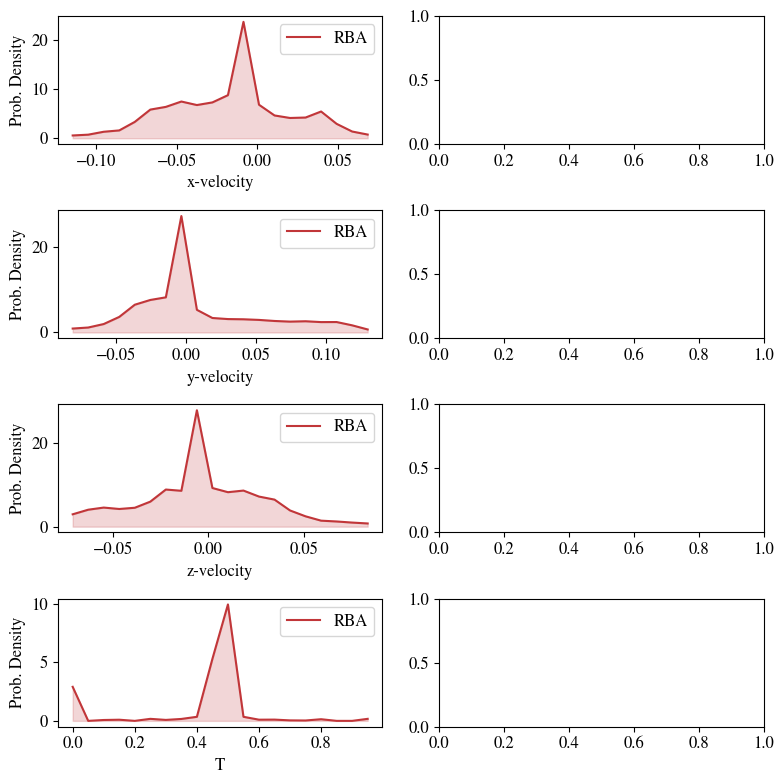

In [ ]:

# %%

def plot_pdf_fields_Res(datasets, field_names, colors, bins=20, figsize=(8, 8)):
    num_fields = len(datasets)
    fig, axs = plt.subplots(num_fields, 2, figsize=figsize)  # 3 columns for data, RBA, and error

    for i, ((data_piv, data_aiv), field_name) in enumerate(zip(datasets, field_names)):
        prob_density_piv, bins_piv = get_pdf(data_piv, bins=bins)
        prob_density_aiv, bins_aiv = get_pdf(data_aiv, bins=bins)
        error = data_piv - data_aiv
        prob_density_error, bins_error = get_pdf(error, bins=bins)

        # Plotting data
        axs[i, 0].plot(bins_aiv[:-1], prob_density_aiv, color=colors[-2], label='RBA')
        axs[i, 0].fill_between(bins_aiv[:-1], prob_density_aiv, color=colors[-2], alpha=0.2)
        axs[i, 0].set_xlabel(f'{field_name}')
        axs[i, 0].set_ylabel('Prob. Density')
        axs[i, 0].legend(loc='upper right')

    plt.tight_layout()
    return fig



# Extracting and reshaping data
u_piv_hist = np.array(jax.device_get(dataset['Test'][:,4:5])).reshape(-1)
u_aiv_hist = np.array(jax.device_get(u_pred_mid)).reshape(-1)
v_piv_hist = np.array(jax.device_get(dataset['Test'][:,5:6])).reshape(-1)
v_aiv_hist = np.array(jax.device_get(v_pred_mid)).reshape(-1)
w_piv_hist = np.array(jax.device_get(dataset['Test'][:,6:7])).reshape(-1)
w_aiv_hist = np.array(jax.device_get(w_pred_mid)).reshape(-1)  # Assuming w_pred is defined
T_piv_hist = np.array(jax.device_get(dataset['Test'][:,7:8])).reshape(-1)
T_aiv_hist = np.array(jax.device_get(T_pred_mid)).reshape(-1)  # Assuming T_pred is defined

bins = 40

# Calculating probability densities
prob_density_u_piv, bins_u_piv = get_pdf(u_piv_hist, bins=bins)
prob_density_u_aiv, bins_u_aiv = get_pdf(u_aiv_hist, bins=bins)
prob_density_v_piv, bins_v_piv = get_pdf(v_piv_hist, bins=bins)
prob_density_v_aiv, bins_v_aiv = get_pdf(v_aiv_hist, bins=bins)
prob_density_w_piv, bins_w_piv = get_pdf(w_piv_hist, bins=bins)
prob_density_w_aiv, bins_w_aiv = get_pdf(w_aiv_hist, bins=bins)
prob_density_T_piv, bins_T_piv = get_pdf(T_piv_hist, bins=bins)
prob_density_T_aiv, bins_T_aiv = get_pdf(T_aiv_hist, bins=bins)



colors = get_colors_plot(cmap='RdBu_r', n_colors=8)
datasets = [(u_aiv_hist, u_aiv_hist), (v_aiv_hist, v_aiv_hist), 
            (w_aiv_hist, w_aiv_hist), (T_aiv_hist, T_aiv_hist)]
field_names = ['x-velocity', 'y-velocity', 'z-velocity', 'T']
mpl.rcParams['font.size'] = 12

fig = plot_pdf_fields_Res(datasets, field_names, colors)

plt.savefig(result_path + '/AIV-Prob_dist_epochs_Res.png')
print('plot')


  0%|          | 0/284 [00:00<?, ?it/s]

  1%|          | 3/284 [00:18<29:22,  6.27s/it]


KeyboardInterrupt: 

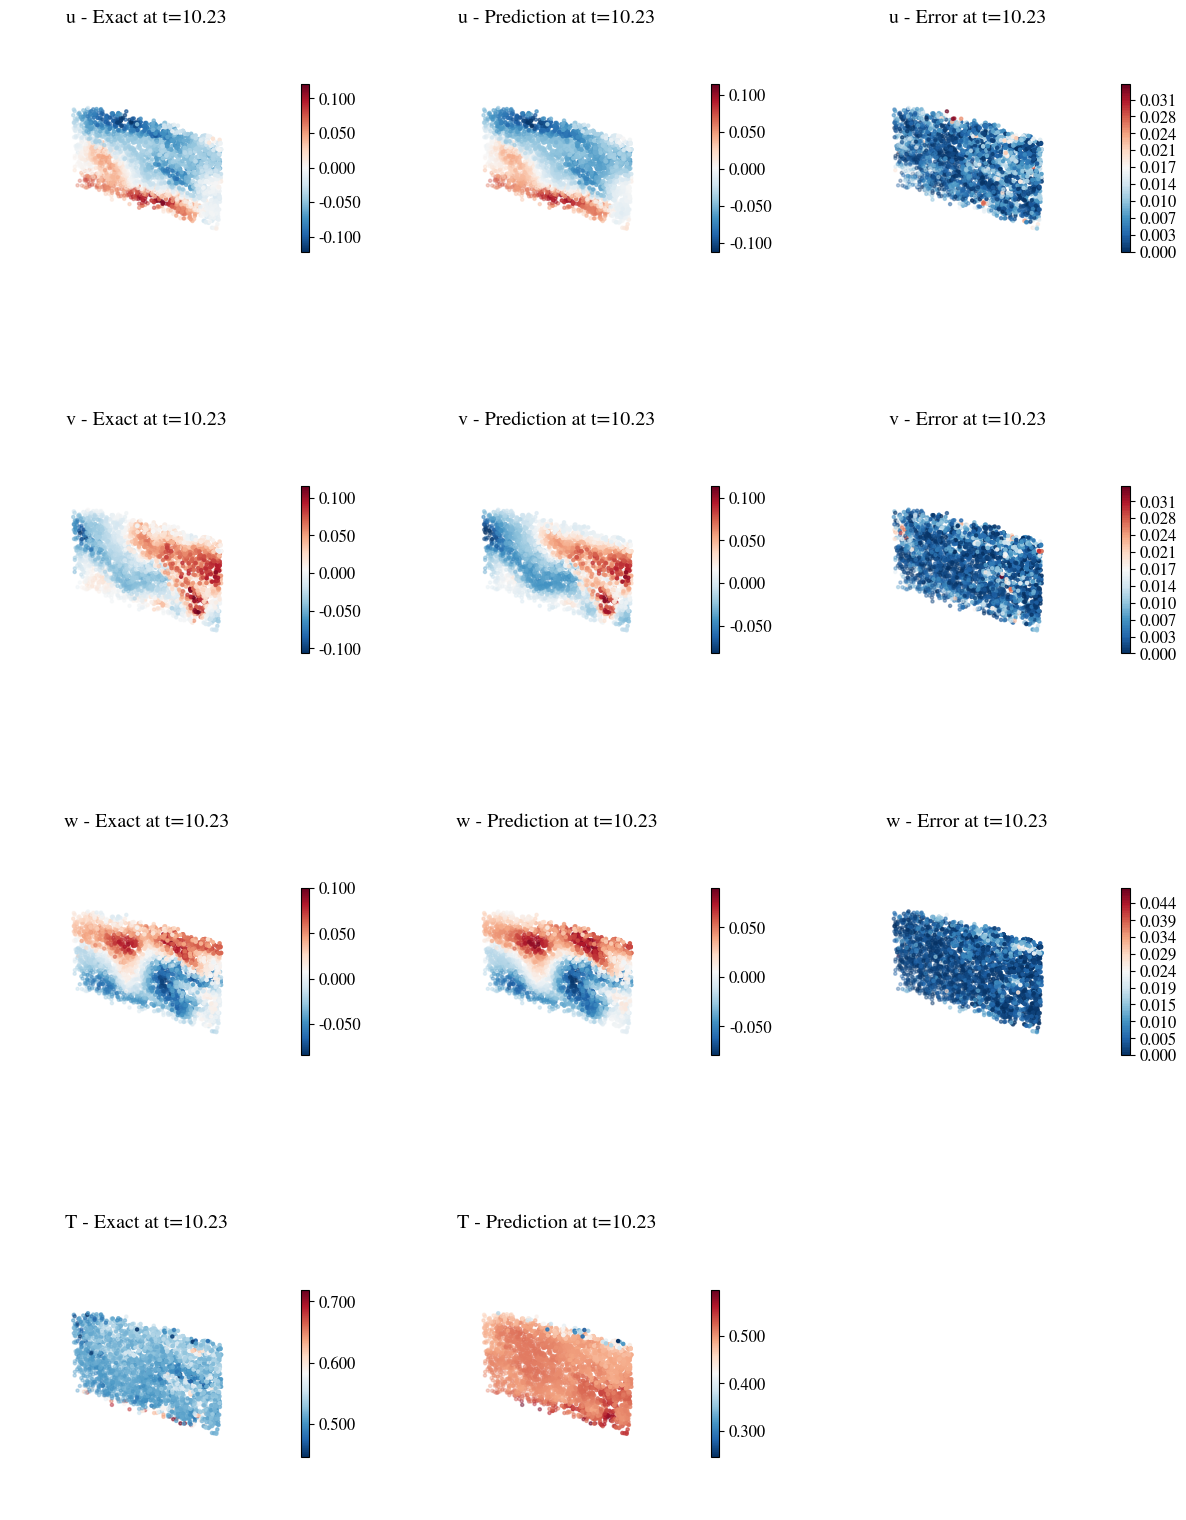

In [ ]:


# %%
Errors_RL2_u=[]
Errors_RL2_v=[]
Errors_RL2_w=[]
Errors_RL2_T=[]

Errors_L_inf_u=[]
Errors_L_inf_v=[]
Errors_L_inf_w=[]
Errors_L_inf_T=[]
dataset['GT']=X_sol
all_times=np.unique(dataset['GT'][:,0]).flatten()

start=0
end=start+1
end=len(all_times)
#mpl.rcParams['font.size'] = 20

for frame in tqdm.tqdm(range(start,end)):
    X_frame=dataset['GT'][dataset['GT'][:,0]==all_times[frame]]
    txyz_frame=X_frame[:,:4]
    u_frame=X_frame[:,4:5]
    v_frame=X_frame[:,5:6]
    w_frame=X_frame[:,6:7]
    T_frame=X_frame[:,7:8]

    u_pred=vmap(u_fx,(0))(txyz_frame)[:,None]
    v_pred=vmap(v_fx,(0))(txyz_frame)[:,None]
    w_pred=vmap(w_fx,(0))(txyz_frame)[:,None]
    T_pred=vmap(T_fx,(0))(txyz_frame)[:,None]

    u_error=relative_error2(u_pred,u_frame)
    v_error=relative_error2(v_pred,v_frame)
    w_error=relative_error2(w_pred,w_frame)
    T_error=relative_error2(T_pred,T_frame)

    Errors_RL2_u.append(u_error)
    Errors_RL2_v.append(v_error)
    Errors_RL2_w.append(w_error)
    Errors_RL2_T.append(T_error)

    abs_u=np.abs(u_pred-u_frame)
    abs_v=np.abs(v_pred-v_frame)
    abs_w=np.abs(w_pred-w_frame)
    abs_T=np.abs(T_pred-T_frame)

    max_u=np.max(abs_u)
    max_v=np.max(abs_v)
    max_w=np.max(abs_w)
    max_T=np.max(abs_T)

    Errors_L_inf_u.append(max_u)
    Errors_L_inf_v.append(max_v)
    Errors_L_inf_w.append(max_w)
    Errors_L_inf_T.append(max_T)
    fig = plt.figure(figsize=(15, 20))

    # Define titles for the columns
    columns = ['Exact', 'Prediction', 'Error']

    # Define max range for error colorbars and the plots
    max_errors = [max_u, max_v, max_w, max_T]

    # Variables to plot
    variables = [(u_frame, u_pred, abs_u), 
                (v_frame, v_pred, abs_v), 
                (w_frame, w_pred, abs_w), 
                (T_frame, T_pred, abs_T)]

    # Calculate the max range for true dimensions
    xyz_max_range = np.array([txyz_frame[:, 1].max() - txyz_frame[:, 1].min(), 
                            txyz_frame[:, 2].max() - txyz_frame[:, 2].min(), 
                            txyz_frame[:, 3].max() - txyz_frame[:, 3].min()]).max() / 2.0

    mid_x = txyz_frame[:, 1].mean()
    mid_y = txyz_frame[:, 3].mean()  # Assuming the order of columns is x, t, y, z
    mid_z = txyz_frame[:, 2].mean()

    # Extract the time value for the current frame
    time_value = all_times[frame]

    for i, (var_exact, var_pred, var_error) in enumerate(variables):
        for j in range(3):
            ax = fig.add_subplot(4, 3, i * 3 + j + 1, projection='3d')
            if j == 0:  # Exact values
                scatter = ax.scatter(txyz_frame[:, 1], txyz_frame[:, 3], txyz_frame[:, 2], c=var_exact.ravel(), cmap='RdBu_r', s=5)
                plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=20).formatter = FormatStrFormatter('%.3f')
            elif j == 1:  # Predictions
                scatter = ax.scatter(txyz_frame[:, 1], txyz_frame[:, 3], txyz_frame[:, 2], c=var_pred.ravel(), cmap='RdBu_r', s=5)
                plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=20).formatter = FormatStrFormatter('%.3f')
            else:  # Errors
                scatter = ax.scatter(txyz_frame[:, 1], txyz_frame[:, 3], txyz_frame[:, 2], c=var_error.ravel(), cmap='RdBu_r', s=5)
                plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=20, boundaries=np.linspace(0, max_errors[i], 100)).formatter = FormatStrFormatter('%.3f')

            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
            ax.set_title(f'{["u", "v", "w", "T"][i]} - {columns[j]} at t={time_value:.2f}')
            
            # Set the same limits for all three axes based on the max range
            ax.set_xlim(mid_x - xyz_max_range, mid_x + xyz_max_range)
            ax.set_ylim(mid_y - xyz_max_range, mid_y + xyz_max_range)
            ax.set_zlim(mid_z - xyz_max_range, mid_z + xyz_max_range)

            plt.axis('off')

    plt.tight_layout()
    plt.savefig(errors_path+f"Errors_at_t={(frame/len(all_times)):.5f}.png")
    if start+1<end:
        plt.close()
    else:
        print('plot')

image_folder= errors_path
video_name=dataset_name+'Errors_all.mp4'
make_video(image_folder, video_name, 20) # 10 is the FPS (frames per second)


# %%
import matplotlib.pyplot as plt

def plot_errors(Errors_RL2, Errors_L_inf, all_times):
    """
    Plot Relative L2 and L-infinity errors for u, v, w, T over frames.

    :param Errors_RL2: List of lists containing Relative L2 errors for u, v, w, T.
    :param Errors_L_inf: List of lists containing L-infinity errors for u, v, w, T.
    :param all_times: Array of time points corresponding to the frames.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Titles for the subplots
    titles = ['Relative L2 Error', 'L-infinity Error']

    # Plotting Relative L2 Errors
    for i, error_list in enumerate(Errors_RL2):
        axes[0].plot(all_times, error_list, label=f'{["u", "v", "w", "T"][i]}')
    axes[0].set_title(titles[0])
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Error')
    axes[0].legend()

    # Plotting L-infinity Errors
    for i, error_list in enumerate(Errors_L_inf):
        axes[1].plot(all_times, error_list, label=f'{["u", "v", "w", "T"][i]}')
    axes[1].set_title(titles[1])
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Error')
    axes[1].legend()

    plt.tight_layout()
    print('plot')

# Assuming Errors_RL2_u, Errors_RL2_v, Errors_RL2_w, Errors_RL2_T,
# Errors_L_inf_u, Errors_L_inf_v, Errors_L_inf_w, Errors_L_inf_T are already defined
Errors_RL2 = [Errors_RL2_u, Errors_RL2_v, Errors_RL2_w, Errors_RL2_T]
Errors_L_inf = [Errors_L_inf_u, Errors_L_inf_v, Errors_L_inf_w, Errors_L_inf_T]

plot_errors(Errors_RL2, Errors_L_inf, all_times)
plt.savefig(result_path + f'Errors_per_all.png')

# %%
print(np.mean(Errors_RL2,axis=1))

# %%


# %%


# %%


# %%
